In [1]:
%load_ext autoreload
%autoreload 2

from maxentnuc.analysis.analysis_orca import *
from neighbor_balance.plotting import apply_matplotlib_style

data_root = '/orcd/home/002/joepaggi/orcd/pool'

apply_matplotlib_style()

In [2]:
from maxentnuc.simulation.model import PolymerModel, write_psf
import MDAnalysis as mda
import numpy as np
import pandas as pd
import tarfile
from tqdm import tqdm


def positions_to_distances(positions):
    # positions: (# conformations, [new dim 1], # loci, [new dim 2],  3)
    return np.linalg.norm(np.expand_dims(positions, -3) - np.expand_dims(positions, -2), axis=-1)


def positions_to_average_distance(positions, average=np.nanmedian):
    return average(positions_to_distances(positions), axis=0)


def positions_to_contacts(positions, thresh):
    distances = positions_to_distances(positions)
    num = (distances < thresh) & ~np.isnan(distances)
    den = ~np.isnan(distances)
    return np.sum(num, axis=0) / np.sum(den, axis=0)


class TrackData:
    def __init__(self, chrom, regions, positions, brightness=None):
        self.chrom = chrom
        self.regions = regions
        self.positions = positions
        self.brightness = brightness
        self.shifted = False

    def __copy__(self):
        return TrackData(self.chrom, self.regions.copy(), self.positions.copy(),
                         self.brightness.copy() if self.brightness is not None else None)

    @classmethod
    def from_trace_core(cls, trace_core_csv, validate=False, filter_func=None, trace_id_name='Trace_ID', custom_processing=None):
        df = cls._read_trace_core_csv(trace_core_csv)
        if custom_processing is not None:
            df = custom_processing(df)

        df['Trace_ID'] = pd.factorize(df['Trace_ID'])[0]
        df = df.loc[df.Trace_ID != -1]
        df = df.loc[df.Chrom_End != 0]
        df['Trace_ID'] = df[trace_id_name].astype(int)
        df['Chrom_Start'] = df['Chrom_Start']
        df['Chrom_End'] = df['Chrom_End']
        df['X'] = df['X'].astype(float)
        df['Y'] = df['Y'].astype(float)
        df['Z'] = df['Z'].astype(float)

        if filter_func is not None:
            df = filter_func(df)

        chrom = df['Chrom'].iloc[0]
        assert all(df['Chrom'] == chrom)

        regions = sorted(set(map(tuple, df[['Chrom_Start', 'Chrom_End']].to_numpy().astype(int))))

        positions = np.zeros((max(df.Trace_ID)+1, len(regions), 3))
        positions[:] = np.nan
        for _, row in df.iterrows():
            region = (row.Chrom_Start, row.Chrom_End)
            if region not in regions:
                continue
            if validate:
                assert np.isnan(positions[row.Trace_ID, regions.index((row.Chrom_Start, row.Chrom_End))]).all(), \
                    f'No duplicate entries: {row.Trace_ID}: {regions.index((row.Chrom_Start, row.Chrom_End))}'
            positions[row.Trace_ID, regions.index((row.Chrom_Start, row.Chrom_End))] = row[['X', 'Y', 'Z']]
        positions = positions[~np.isnan(positions).all(axis=(1, 2))]
        return TrackData(chrom, regions, positions)

    @classmethod
    def _read_trace_core_csv(cls, trace_core_csv):
        with open(trace_core_csv) as f:
            for line in f:
                if 'columns=' in line:
                    columns = line.split('(')[1].split(')')[0].split(',')
                    columns = [x.strip() for x in columns]
                    break
            else:
                columns = None

        df = pd.read_csv(trace_core_csv, comment='#', names=columns, header=None, low_memory=False)
        return df

    @classmethod
    def from_dipc(cls, path, chrom, start, end, test=False, scale=1000):
        tar = tarfile.open(path, "r:*")
        sub_paths = tar.getnames()
        if test:
            sub_paths = sub_paths[:10]

        dfs = []
        for sub_path in tqdm(sub_paths):
            df = pd.read_csv(
                tar.extractfile(sub_path),
                sep='\t',
                header=None,
                encoding='utf-8',
                comment='#',
                names=['Chromosome', 'Genomic_Index', 'x', 'y', 'z'],
                compression='gzip',
            )

            for a in ['a', 'b']:
                d = df.loc[(df.Chromosome == chrom + a) & (df.Genomic_Index >= start) & (df.Genomic_Index <= end)]
                d.loc[:, 'Chromosome'] = chrom
                d = d.set_index(['Chromosome', 'Genomic_Index'])
                d *= scale
                dfs += [d]

        assert all(df.index.equals(dfs[0].index) for df in dfs)
        regions = dfs[0].index.get_level_values('Genomic_Index')
        interval = regions[1] - regions[0]
        regions = [(s, s + interval) for s in regions]
        coords = np.array([df[['x', 'y', 'z']].to_numpy() for df in dfs])
        return TrackData(chrom, regions, coords)

    @classmethod
    def get_common_regions(cls, tracks):
        regions = sorted(set([region for track in tracks for region in track.regions]))
        return [region for region in regions if all(region in track.regions for track in tracks)]

    @classmethod
    def get_intersection(cls, tracks):
        start = max(track.regions[0][0] for track in tracks)
        end = min(track.regions[-1][1] for track in tracks)
        return start, end

    @classmethod
    def join(cls, tracks):
        chrom = tracks[0].chrom
        assert all(track.chrom == chrom for track in tracks)
        regions = tracks[0].regions
        assert all(track.regions == regions for track in tracks)
        positions = np.vstack([track.positions for track in tracks])
        if all(track.brightness is not None for track in tracks):
            brightness = np.vstack([track.brightness for track in tracks])
        else:
            brightness = None
        return TrackData(chrom, regions, positions, brightness)

    def shift_coordinates(self, shift):
        assert not self.shifted, 'Coordinates have already been shifted'
        self.shifted = True
        self.regions = [(x + shift, y + shift) for x, y in self.regions]

    def select_region(self, start, end):
        index = [i for i, (x, y) in enumerate(self.regions) if start <= x <= end and start <= y <= end]
        positions = self.positions[:, index]
        regions = [self.regions[i] for i in index]
        if self.brightness is not None:
            brightness = self.brightness[:, index]
        else:
            brightness = None
        return TrackData(self.chrom, regions, positions, brightness)

    def coarsen(self, regions):
        positions = np.zeros((self.positions.shape[0], len(regions), 3))
        for i, region in enumerate(regions):
            w = 0
            for j, (s, e) in enumerate(self.regions):
                assert (e - s) <= (region[1] - region[0]),f'Attempting to coarsen but target is smaller than source {s}-{e} vs {region[0]}-{region[1]}'
                s_in_region = region[0] <= s <= region[1]
                e_in_region = region[0] <= e <= region[1]
                if s_in_region and e_in_region:
                    _w = 1
                elif s_in_region and not e_in_region:
                    _w = (e - region[0]) / (e - s)
                elif not s_in_region and e_in_region:
                    _w = (region[1] - s) / (e - s)
                else:
                    _w = 0
                w += _w
                positions[:, i] += _w * self.positions[:, j]
            positions[:, i] /= w
        return TrackData(self.chrom, regions, positions)

    def x(self):
        return np.array([(x + y) / 2 for x, y in self.regions])

    def is_compact(self):
        for i in range(len(self.regions) - 1):
            if self.regions[i][1] + 1 < self.regions[i + 1][0]:
                print(f'Non-compact region: {self.regions[i]}')
                return False
        return True

    def write_trajectory(self, name, nan_fraction=0.05):
        positions = self.positions.copy()
        positions = self.positions[np.mean(np.isnan(positions[:, :, 0]), axis=1) < nan_fraction]
        positions -= np.nanmean(positions, axis=1, keepdims=True)
        positions[np.isnan(positions)] = 0

        u = mda.Universe.empty(positions.shape[1], trajectory=True).load_new(positions)
        sele = u.select_atoms('all')
        with mda.Writer(f"{name}.dcd", n_atoms=positions.shape[1], multiframe=True) as writer:
            for ts in u.trajectory:
                writer.write(sele)

        model = PolymerModel(positions.shape[1])
        model.define_topology()
        write_psf(model.topology, f'{name}.psf')

In [3]:
def read_sox2_tastemel(data_root='orca'):
    # Add the below number to get from mm10 to mm39 for the sox2 locus.
    # mm39: chr3:33,814,000-35,694,000 -> mm10: chr3:33,759,851-35,639,851
    MM10_TO_MM39 = 33_814_000 - 33_759_851

    paths = {'2025 RAD21 control': '4DNFI1D6S3HM',
             '2025 CTCF control': '4DNFI613CB75',

             '2021 mutant': '4DNFIA8DHAFV',
             '2021 between': '4DNFI5Y2PIJM',
             '2021 down': '4DNFI2RCYFJU'
    }

    orca = {}
    for name, path in paths.items():
        if '2025' in name:
            custom_processing = None
            def filter_func(df):
                df = df.loc[df['Extra_Cell_ROI_ID'] == '129']
                df = df.loc[df['Chrom_Start'] != df['Chrom_End']]
                return df
            trace_id_name = 'Cell_ID'
        else:
            def custom_processing(df):
                df['Trace'] = [x.split('_')[0] for x in df['Trace_ID']]
                df['Allele'] = [x.split('_')[1] for x in df['Trace_ID']]
                return df
            def filter_func(df):
                df = df.loc[df.Allele == '129']
                df = df.loc[df['Chrom_Start'] != df['Chrom_End']]
                return df
            trace_id_name = 'Trace'
        orca[name] = TrackData.from_trace_core(f'{data_root}/{path}.csv', trace_id_name=trace_id_name, filter_func=filter_func, custom_processing=custom_processing)

    for name, track in orca.items():
        track.shift_coordinates(MM10_TO_MM39)

    for name, track in orca.items():
        assert track.is_compact()
    return orca

chrom, start, end = 'chr3', 33_914_000, 35_594_000  # full RCMC region
orca = read_sox2_orca(data_root='/home/joepaggi/orcd/pool/omics', wt_only=True)
orca.update(read_sox2_tastemel())

In [4]:
orca['Huang 2021'] = TrackData.join([orca['2021 mutant'], orca['2021 between'], orca['2021 down']])
orca['Tastemal 2025'] = TrackData.join([orca['2025 RAD21 control'], orca['2025 CTCF control']])

In [5]:
for name, track in orca.items():
    print(name, track.regions[0], track.regions[-1])

wt (np.int64(33354150), np.int64(33384150)) (np.int64(36204245), np.int64(36234245))
2025 RAD21 control (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
2025 CTCF control (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
2021 mutant (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
2021 between (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
2021 down (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
Huang 2021 (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))
Tastemal 2025 (np.int64(34655227), np.int64(34660227)) (np.int64(34855227), np.int64(34860227))


In [6]:
for name, track in orca.items():
    print(name, len(track.positions), np.mean(np.isnan(track.positions)))

wt 2355 0.2153927813163482
2025 RAD21 control 829 0.3388743416987849
2025 CTCF control 824 0.3015332701870708
2021 mutant 659 0.314001258373737
2021 between 784 0.3402501244400199
2021 down 571 0.341975994190765
Huang 2021 2014 0.3321505558650423
Tastemal 2025 1653 0.3202602806427338


In [7]:
for name, track in orca.items():
    loci_length = track.regions[0][1] - track.regions[0][0]
    loci_sep = track.regions[1][0] - track.regions[0][1]
    for i in range(len(track.regions)):
        _loci_length = track.regions[i][1] - track.regions[i][0]
        if loci_length != _loci_length:
            print(f'{name} loci length mismatch: {loci_length} vs {_loci_length} at index {i} {track.regions[i]}')

In [8]:
prototype = '2021 mutant'
n = len(orca[prototype].regions)

for name, track in orca.items():
    if len(track.regions) != n:
        print(f'{name} has different number of regions: {len(track.regions)} vs {n}')

for name, track in orca.items():
    if name == 'wt': continue
    for i in range(n):
        if  orca[prototype].regions[i][0] != track.regions[i][0] or orca[prototype].regions[i][1] != track.regions[i][1]:
            print(f'{i} {orca[prototype].regions[i]} vs {track.regions[i]}')

wt has different number of regions: 96 vs 41


# ORCA full regions

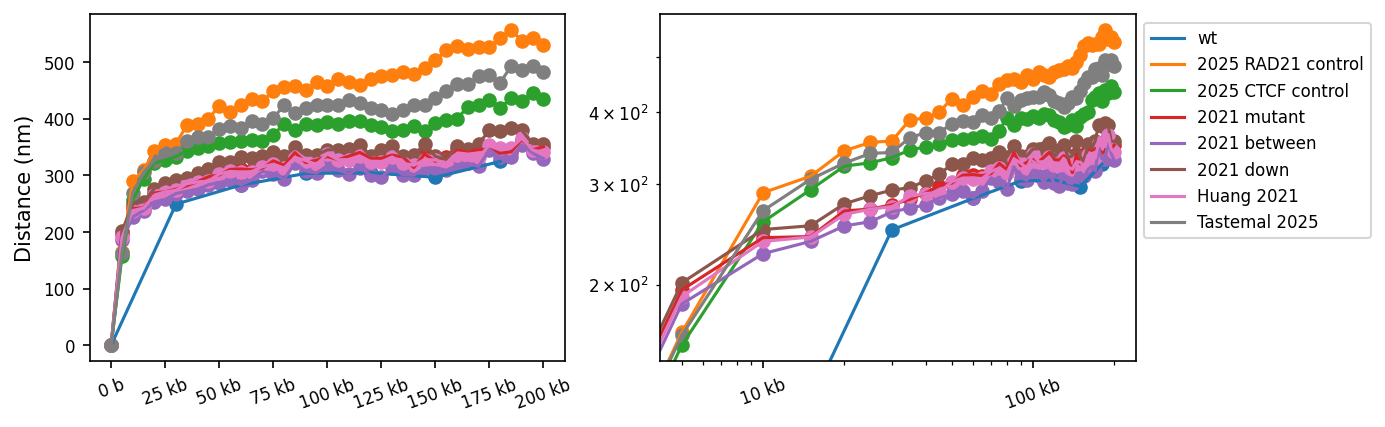

In [9]:
def positions_to_distances(positions):
    # positions: (# conformations, [new dim 1], # loci, [new dim 2],  3)
    return np.linalg.norm(np.expand_dims(positions, -3) - np.expand_dims(positions, -2), axis=-1)

def positions_to_average_distance(positions, average=np.nanmedian):
    return average(positions_to_distances(positions), axis=0)

def get_section_distances(positions):
    dists = positions_to_average_distance(positions)
    section_dists = []
    for i in range(dists.shape[0]):
        section_dists += [np.nanmedian(np.diagonal(dists, i))]
    return np.array(section_dists)

def plot_distance_scaling(ax, name, track, cut=20, c=None, ls=None, distance_scale=1, scatter=True):
    x = track.x()
    x -= x[0]
    dists = distance_scale * get_section_distances(track.positions)

    # popt, _ = curve_fit(power_law, x[cut:], dists[cut:])
    # a, b = popt
    for j in range(2):
        ax[j].plot(x, dists, label=name, color=c, ls=ls)
        if scatter:
            ax[j].scatter(x, dists, color=c, marker='o')

    ax[0].set_ylabel('Distance (nm)')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    format_ticks(ax[0], y=False)
    format_ticks(ax[1], y=False)
    return ax

tastemal_start = orca['2025 RAD21 control'].regions[0][0]
tastemal_end = orca['2025 RAD21 control'].regions[-1][1]
f, ax = plt.subplots(1, 2, figsize=(9, 3))
cut=3
for name, track in orca.items():
    track = track.select_region(tastemal_start-15000, tastemal_end + 15000)
    plot_distance_scaling(ax, name, track, cut=cut, scatter=True)

ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [10]:
nanog_chrom, nanog_start, nanog_end = 'chr6', 122455000, 122875000 # simulated region
mei_runs = '/home/joepaggi/share/mei_runs'
nanog_orca = read_nanog_orca(data_root='/home/joepaggi/orcd/pool/omics')
index_imaged, index_5kb, index_15kb = nanog_index()

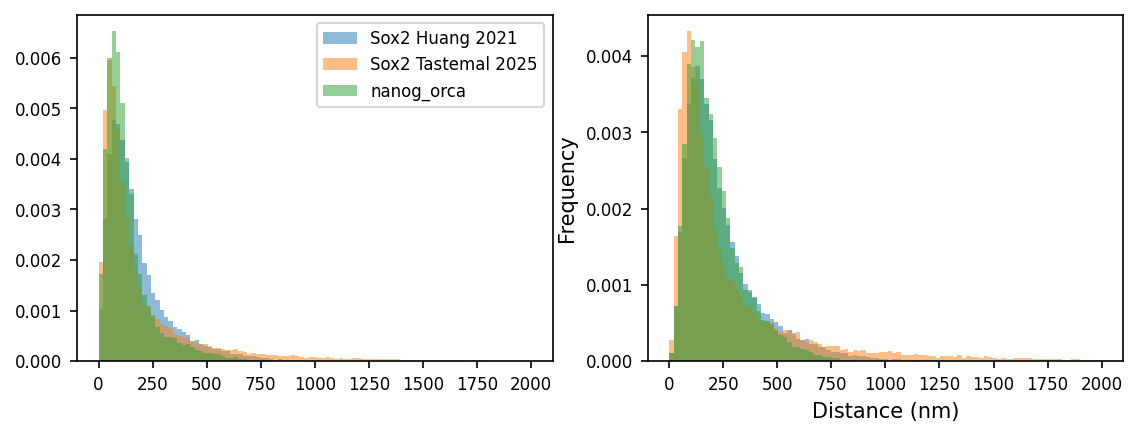

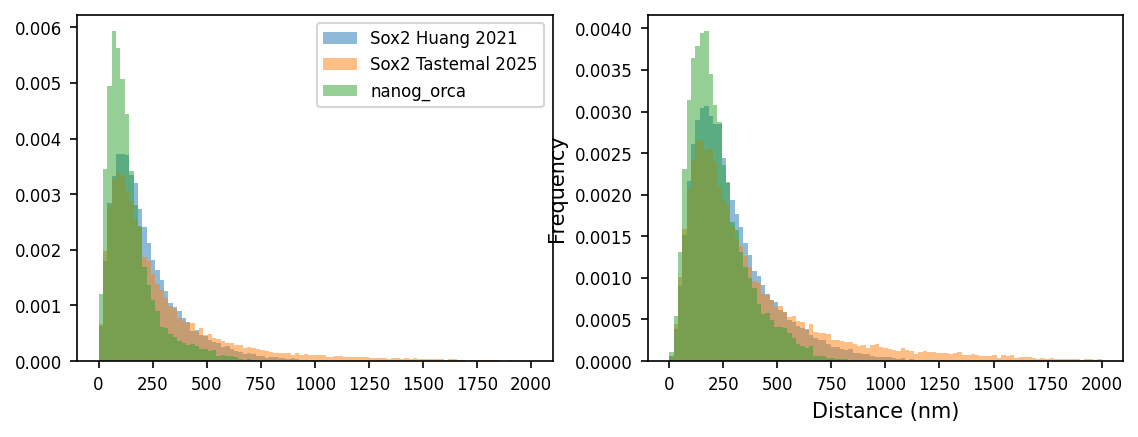

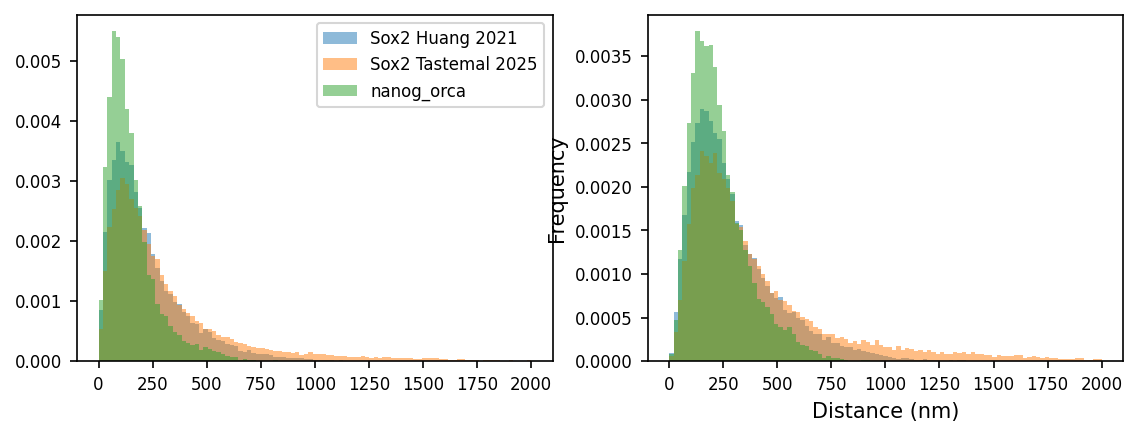

In [11]:
high = 2000
bins = np.linspace(0, high, 100)

for space in [1, 2, 3]:
    # Compare ORCA
    f, ax = plt.subplots(1, 2, figsize=(9, 3))
    for k in [2, 3]:
        for name in ['Huang 2021', 'Tastemal 2025']:
            positions = orca[name].positions[:, :, :k]
            dists = np.linalg.norm(positions[:, space:] - positions[:, :-space], axis=-1)
            ax[k-2].hist(dists.flatten(), bins=bins, label='Sox2 ' + name, density=True, alpha=0.5)

        positions = nanog_orca['rep1']['esc'].positions[:, index_5kb, :k]
        dists = np.linalg.norm(positions[:, space:] - positions[:, :-space], axis=-1)
        ax[k-2].hist(dists.flatten(), bins=bins, label='nanog_orca', density=True, alpha=0.5)
    ax[0].legend()
    plt.xlabel('Distance (nm)')
    plt.ylabel('Frequency')
    plt.show()

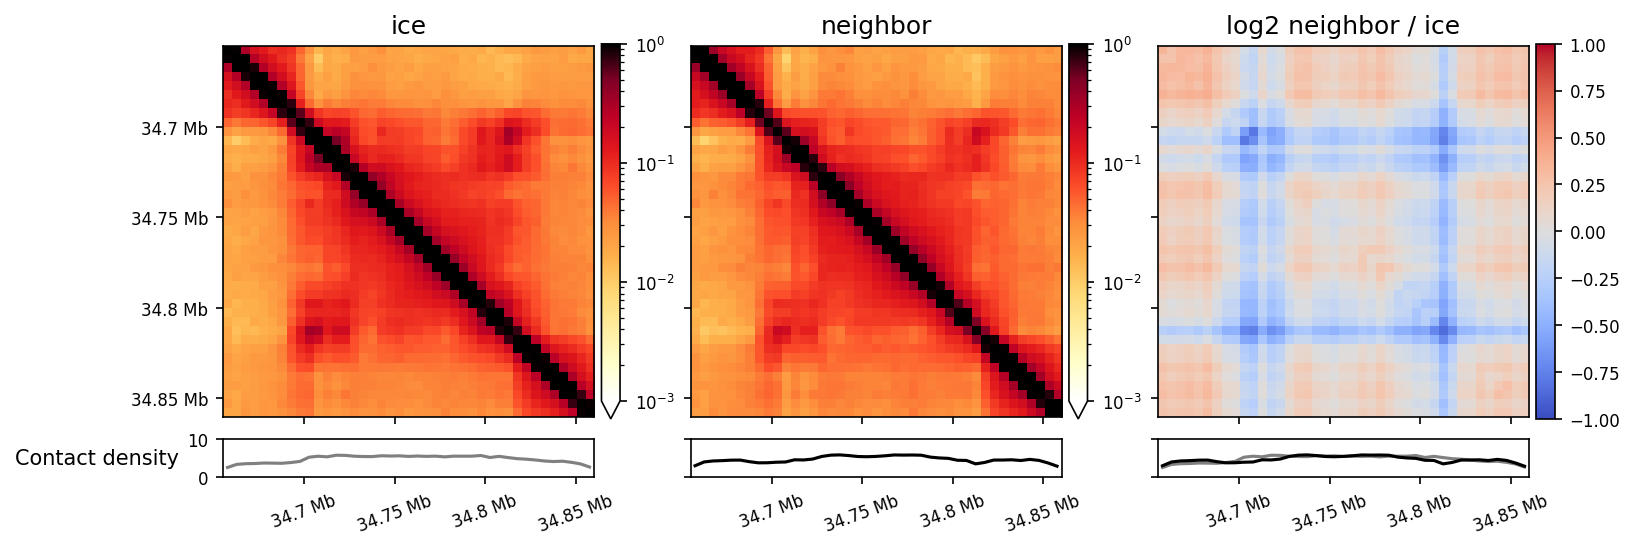

In [14]:
regions = orca['2021 mutant'].select_region(start, end).regions
# The regions are each 30_001 bp long which creates problems with the coarse-graining...
regions = [(round(s / 100.0) * 100, round(e / 100.0) * 100) for s, e in regions]
ice_contact_map, neighbor_contact_map = load_contact_maps('region_contact_maps/WT_merged/sox2.npz', regions)

f, ax = neighbor_contact_map.compare(ice_contact_map, 'neighbor', 'ice', density_max=10, diff_vmax=1)
plt.show()

In [15]:
# Load simulation data.
mei_runs = '/orcd/data/binz/001/joepaggi/mei_runs'
conditions = {
    'simulation': {'base': f'{mei_runs}/sox2/v11/013', 'scale':0.1},

    # 'v17': {'base': f'{mei_runs}/sox2/v11/017', 'scale':0.1},
    # 'v18': {'base': f'{mei_runs}/sox2/v11/018', 'scale':0.1},
    # 'v19': {'base': f'{mei_runs}/sox2/v11/019', 'scale':0.1},
}
conditions = expand_conditions(conditions)
track = orca['Huang 2021']
simulation_tastemal = load_simulations(track.regions, conditions, chrom, start, end, skip=11)

print(track.regions)

simulation


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


[(np.int64(34655227), np.int64(34660227)), (np.int64(34660227), np.int64(34665227)), (np.int64(34665227), np.int64(34670227)), (np.int64(34670227), np.int64(34675227)), (np.int64(34675227), np.int64(34680227)), (np.int64(34680227), np.int64(34685227)), (np.int64(34685227), np.int64(34690227)), (np.int64(34690227), np.int64(34695227)), (np.int64(34695227), np.int64(34700227)), (np.int64(34700227), np.int64(34705227)), (np.int64(34705227), np.int64(34710227)), (np.int64(34710227), np.int64(34715227)), (np.int64(34715227), np.int64(34720227)), (np.int64(34720227), np.int64(34725227)), (np.int64(34725227), np.int64(34730227)), (np.int64(34730227), np.int64(34735227)), (np.int64(34735227), np.int64(34740227)), (np.int64(34740227), np.int64(34745227)), (np.int64(34745227), np.int64(34750227)), (np.int64(34750227), np.int64(34755227)), (np.int64(34755227), np.int64(34760227)), (np.int64(34760227), np.int64(34765227)), (np.int64(34765227), np.int64(34770227)), (np.int64(34770227), np.int64(347

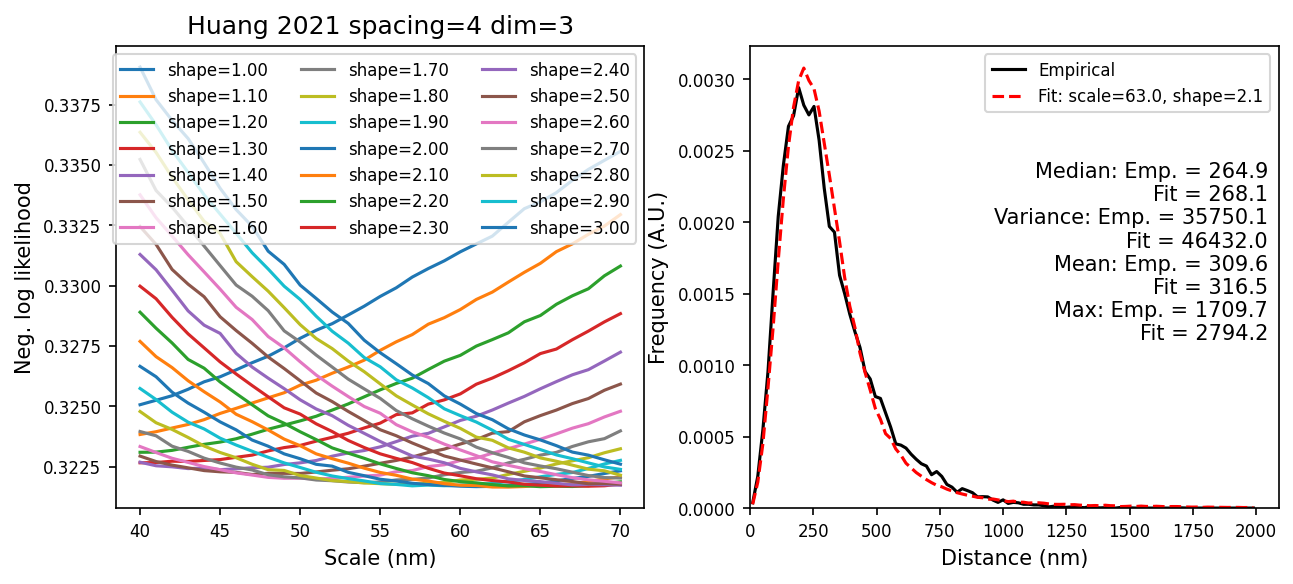

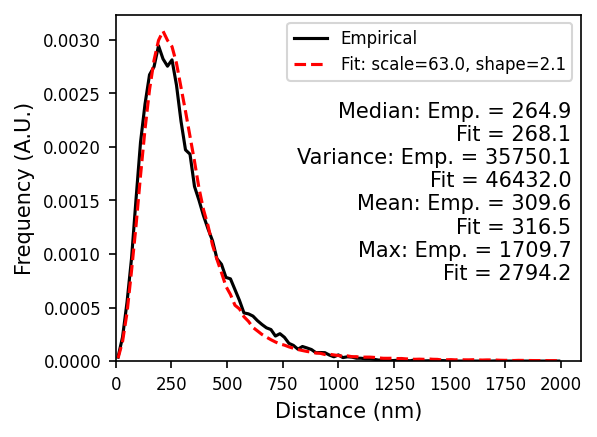

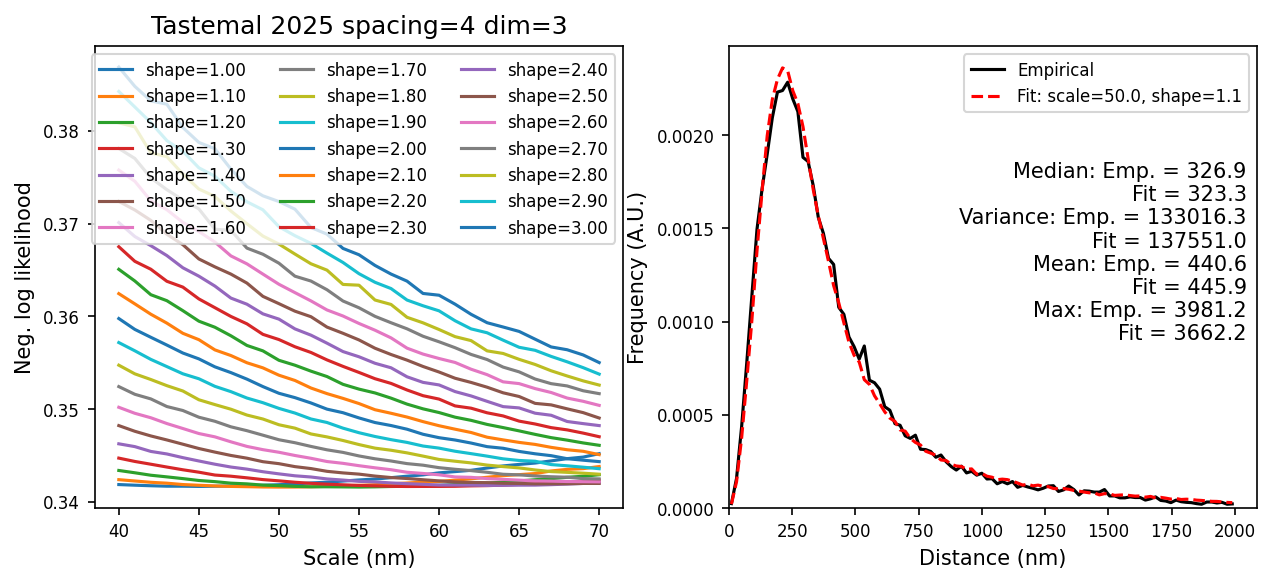

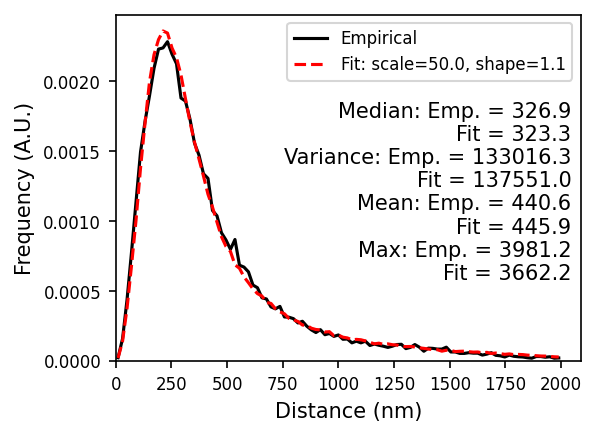

In [ ]:
trials = [('Huang 2021', 3, 'simulation'), ('Tastemal 2025', 3, 'simulation')]
simulation = simulation_tastemal

for rep, k, sim in trials:
    for spacing in [4]:
        for dist in ['t']:
            for metric in ['ll',]:
                orca_positions = orca[rep].select_region(start, end).positions[:, :, :k]
                sim_positions = simulation[sim].select_region(start, end).positions[:, :, :k]
                bins = np.linspace(0, 2000, 100)
                scale_space = (40, 70, 31)
                samples = 10_000

                noisedist = NoiseDistribution(dist='t', max_val=2000)
                noisedist.fit_noise(orca_positions, bins, sim_positions=sim_positions,
                                    samples=samples, spacing=spacing, metric=metric,
                                    scale_space=scale_space)
                ax = noisedist.plot_noise_fit()
                ax[0].set_title(f'{rep} spacing={spacing} dim={k}')
                plt.show()

                ax = noisedist.plot_best_fit()
                plt.show()

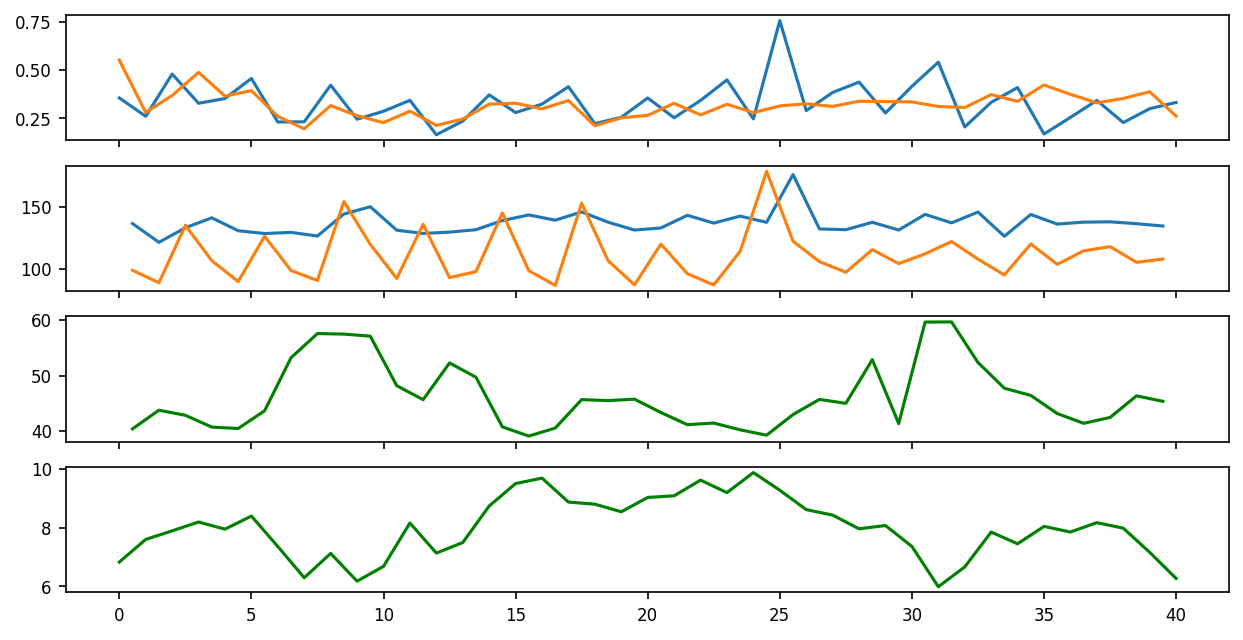

In [ ]:
f, ax = plt.subplots(4, figsize=(10, 5), sharex=True)
x = np.arange(41)
for name in ['Huang 2021', 'Tastemal 2025']:
    positions= orca[name].positions[:, :, :2]
    sim_positions = simulation_tastemal['simulation'].positions[:, :, :2]
    ax[0].plot(x, np.isnan(positions[:, :, 0]).mean(axis=0))
    ax[1].plot(x[:-1] + 0.5, np.nanmedian(np.linalg.norm(positions[:, 1:] - positions[:, :-1], axis=-1), axis=0))
ax[2].plot(x[:-1] + 0.5, np.nanmedian(np.linalg.norm(sim_positions[:, 1:] - sim_positions[:, :-1], axis=-1), axis=0), c='green')
ax[3].plot(x, np.sum(neighbor_contact_map.contact_map, axis=0), c='green')
plt.show()

# nan = np.isnan(positions[:, :, 0]).mean(axis=0)
# plt.scatter(nan[1:] + nan[:-1], np.nanmean(np.linalg.norm(positions[:, 1:] - positions[:, :-1], axis=-1), axis=0))

In [16]:
noise = {
    'Huang 2021': NoiseDistribution(dist='t', scale=66.0, shape=2.2, max_val=2000),
    'Tastemal 2025': NoiseDistribution(dist='t', scale=55.0, shape=1.2, max_val=2000)
}

# k = 2
# noise = {
#     'Huang 2021': NoiseDistribution(dist='t', scale=64.0, shape=2.2, max_val=2000),
#     'Tastemal 2025': NoiseDistribution(dist='t', scale=54.0, shape=1.2, max_val=2000)
# }

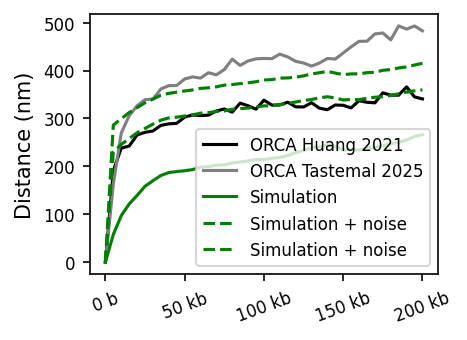

In [17]:
def positions_to_distances(positions):
    # positions: (# conformations, [new dim 1], # loci, [new dim 2],  3)
    return np.linalg.norm(np.expand_dims(positions, -3) - np.expand_dims(positions, -2), axis=-1)

def positions_to_average_distance(positions, average=np.nanmedian):
    return average(positions_to_distances(positions), axis=0)

def get_section_distances(positions):
    dists = positions_to_average_distance(positions)
    section_dists = []
    for i in range(dists.shape[0]):
        section_dists += [np.nanmedian(np.diagonal(dists, i))]
    return np.array(section_dists)

def plot_distance_scaling(ax, name, track, c=None, ls=None, distance_scale=1, scatter=True, k=3):
    x = track.x()
    x -= x[0]
    dists = distance_scale * get_section_distances(track.positions[:, :, :k])

    ax.plot(x, dists, label=name, color=c, ls=ls)
    if scatter:
        ax.scatter(x, dists, color=c)

    ax.set_ylabel('Distance (nm)')
    format_ticks(ax, y=False)
    return ax

k = 3
f, ax = plt.subplots(figsize=(3, 9/4))
track = orca['Huang 2021']
plot_distance_scaling(ax, 'ORCA Huang 2021', track, c='black', scatter=False, k=k)

track = orca['Tastemal 2025']
plot_distance_scaling(ax, 'ORCA Tastemal 2025', track, c='gray', scatter=False, k=k)

track = simulation_tastemal['simulation']
plot_distance_scaling(ax, 'Simulation', simulation_tastemal['simulation'], c='green', scatter=False, k=k)

track_noisy = track.__copy__()
track_noisy.positions = noise['Huang 2021'].add_noise(track_noisy.positions, samples=50)
plot_distance_scaling(ax, f'Simulation + noise', track_noisy, c='green', ls='--', scatter=False, k=k)

track_noisy = track.__copy__()
track_noisy.positions = noise['Tastemal 2025'].add_noise(track_noisy.positions, samples=50)
plot_distance_scaling(ax, f'Simulation + noise', track_noisy, c='green', ls='--', scatter=False, k=k)

ax.legend()
plt.savefig('img/orca_new_sox2_scaling.pdf')
plt.show()

# Scatter plots

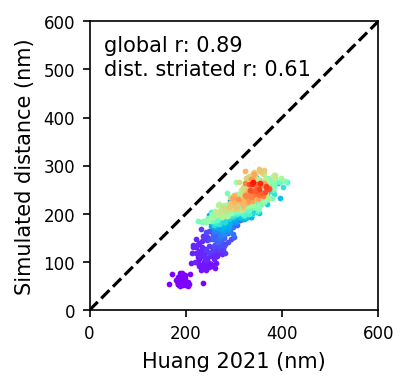

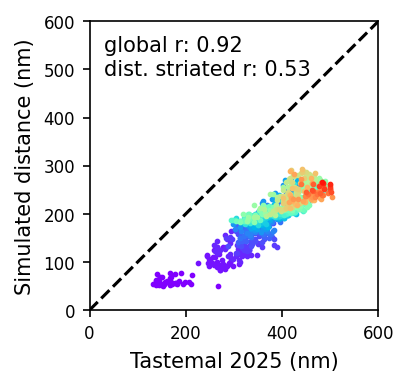

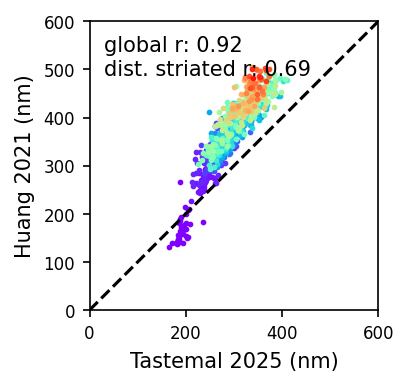

In [18]:
def compare(X, Y, ax=None, plot=True):
    n = X.shape[0]
    colors = cm.rainbow(np.linspace(0, 1, n))
    corr = []

    for offset, color in zip(range(1, n), colors):
        x, y = np.diagonal(X, offset), np.diagonal(Y, offset)
        if plot:
            ax.scatter(x, y, label=f'offset={offset}', color=color, s=3)
        if len(x) > 3:
            corr += [pearsonr(x, y)[0]]
    return corr, pearsonr(full_to_triu(X, k=1), full_to_triu(Y, k=1))

for orca_name in ['Huang 2021', 'Tastemal 2025']:
    f, ax = plt.subplots(figsize=(2.5, 2.5))
    offset_corr, global_corr = compare(positions_to_average_distance(orca[orca_name].positions),
                                       positions_to_average_distance(simulation_tastemal['simulation'].positions), ax=ax)
    text = f'global r: {global_corr[0]:.2f}\ndist. striated r: {np.mean(offset_corr):.2f}'
    ax.text(0.05, 0.95, text, transform=ax.transAxes, va='top', ha='left')
    ax.set_ylabel('Simulated distance (nm)')
    ax.set_xlabel(f'{orca_name} (nm)')
    ax.set_aspect('equal')
    ax.plot([0, 600], [0, 600], 'k--')
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 600)
    plt.savefig(f'img/orca_new_sox2_{orca_name.split(" ")[1]}_scatter.pdf')
    plt.show()


f, ax = plt.subplots(figsize=(2.5, 2.5))
offset_corr, global_corr = compare(positions_to_average_distance(orca['Huang 2021'].positions),
                                   positions_to_average_distance(orca['Tastemal 2025'].positions), ax=ax)
text = f'global r: {global_corr[0]:.2f}\ndist. striated r: {np.mean(offset_corr):.2f}'
ax.text(0.05, 0.95, text, transform=ax.transAxes, va='top', ha='left')
ax.set_ylabel('Huang 2021 (nm)')
ax.set_xlabel('Tastemal 2025 (nm)')
ax.set_aspect('equal')
ax.plot([0, 600], [0, 600], 'k--')
ax.set_ylim(0, 600)
ax.set_xlim(0, 600)
plt.savefig(f'img/orca_new_sox2_exp_scatter.pdf')
plt.show()

orca distance (nm) orca distance 2 (nm)
orca distance (nm) - log rcmc contacts
orca distance (nm) - log rcmc neighbor contacts
orca distance (nm) simulation distance (nm)
orca distance (nm) simulation noisy distance (nm)
orca distance 2 (nm) - log rcmc contacts
orca distance 2 (nm) - log rcmc neighbor contacts
orca distance 2 (nm) simulation distance (nm)
orca distance 2 (nm) simulation noisy distance (nm)
- log rcmc contacts - log rcmc neighbor contacts
- log rcmc contacts simulation distance (nm)
- log rcmc contacts simulation noisy distance (nm)
- log rcmc neighbor contacts simulation distance (nm)
- log rcmc neighbor contacts simulation noisy distance (nm)
simulation distance (nm) simulation noisy distance (nm)


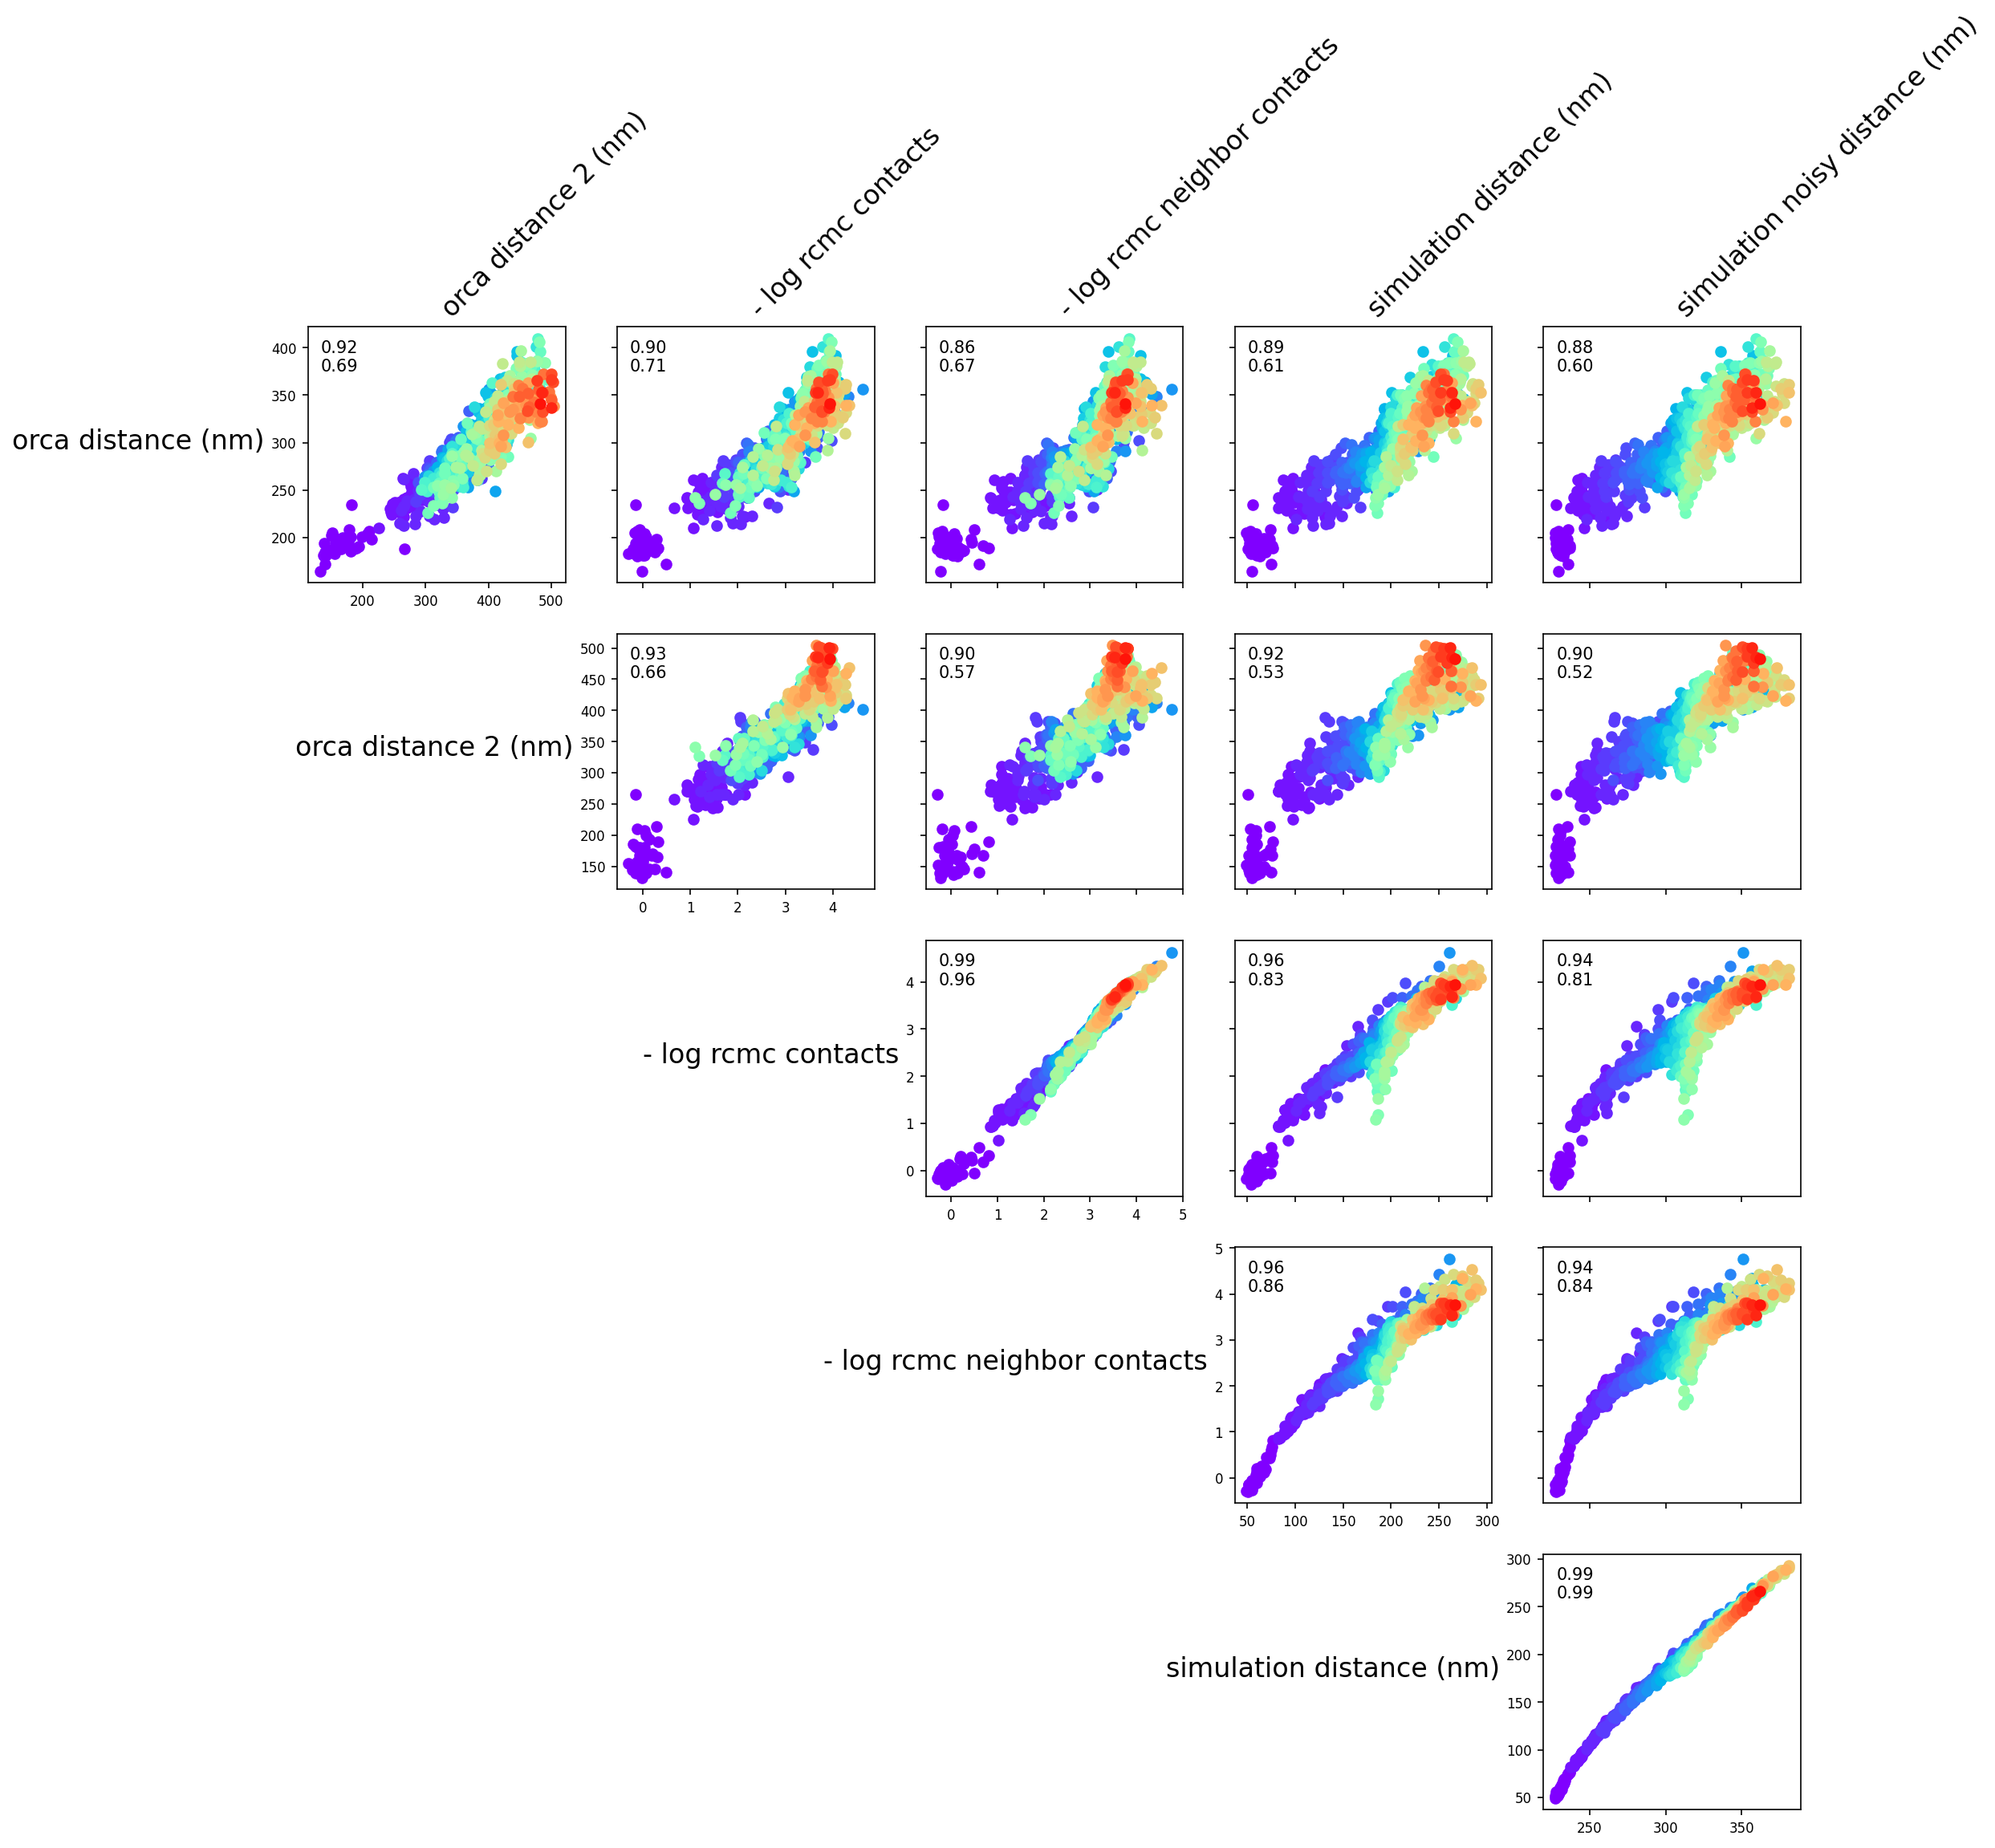

In [19]:
measurements = [
    ('orca distance (nm)', positions_to_average_distance(orca['Huang 2021'].select_region(start, end).positions)),
    ('orca distance 2 (nm)', positions_to_average_distance(orca['Tastemal 2025'].select_region(start, end).positions)),
    #('dipc (nm)', positions_to_average_distance(dipc.coarsen(orca['wt'].select_region(start, end).regions).positions)),
    ('- log rcmc contacts', - np.log(ice_contact_map.contact_map)),
    ('- log rcmc neighbor contacts', - np.log(neighbor_contact_map.contact_map))
]
for name in simulation_tastemal:
    measurements += [(f'{name} distance (nm)', positions_to_average_distance(simulation_tastemal[name].positions))]
    
    sim_noisy = simulation_tastemal[name].__copy__()
    sim_noisy.positions = noise['Huang 2021'].add_noise(sim_noisy.positions, samples=50)
    measurements += [(f'{name} noisy distance (nm)', positions_to_average_distance(sim_noisy.positions))]

scatter_grid(measurements)
plt.show()

simulation
0 1 36 9
1 12 36 9
2 24 36 9
3 36 36 9


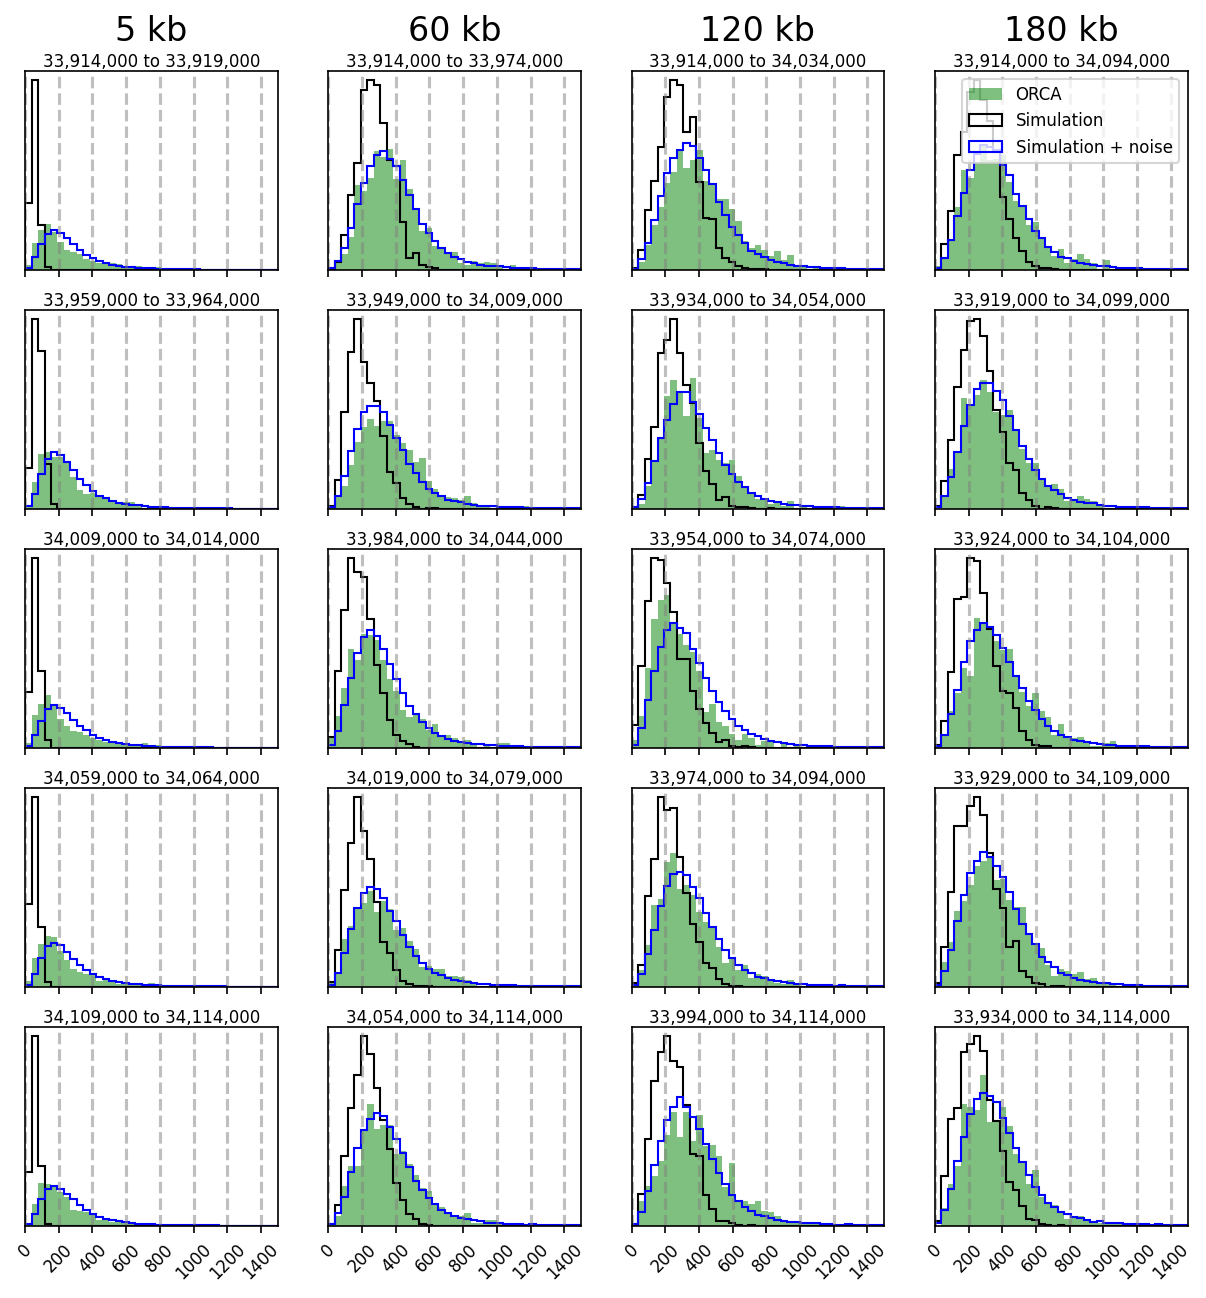

simulation


0 1 36 9
1 12 36 9
2 24 36 9
3 36 36 9


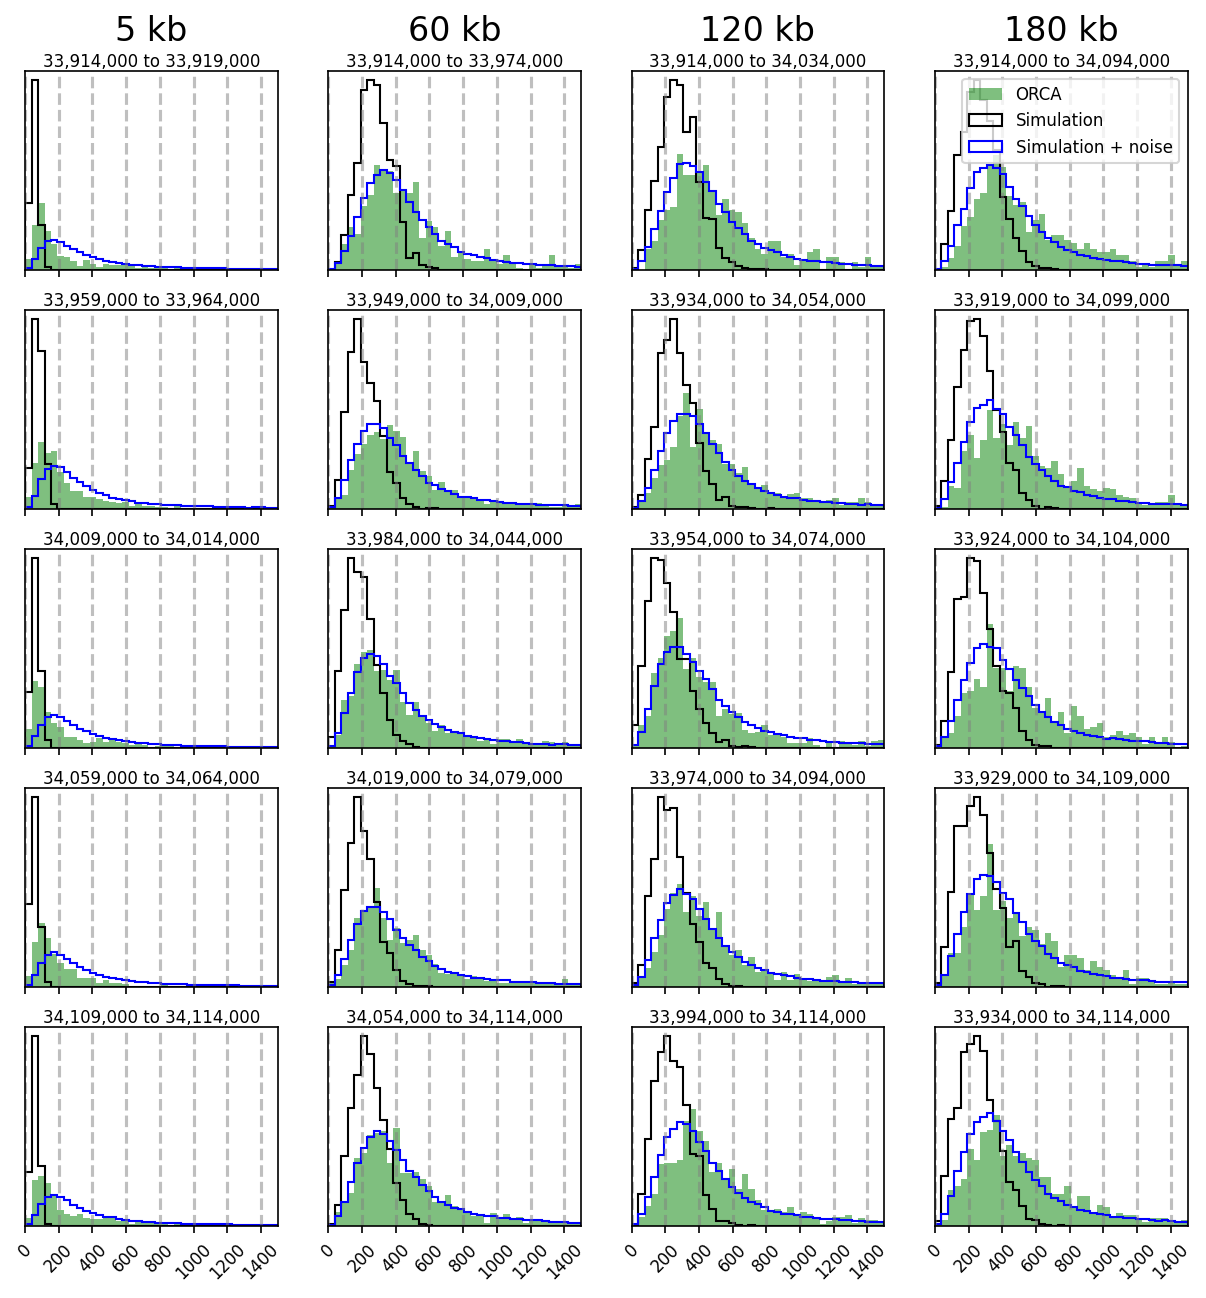

In [20]:
name = 'simulation'
k = 3
for orca_name in ['Huang 2021', 'Tastemal 2025']:
    print(name)
    sim = positions_to_distances(simulation_tastemal[name].positions[:, :, :k])
    sim_noisy = simulation_tastemal[name].__copy__()
    sim_noisy.positions = noise[orca_name].add_noise(sim_noisy.positions, samples=50)
    sim_noisy = positions_to_distances(sim_noisy.positions[:, :, :k])
    orca_rep1 = positions_to_distances(orca[orca_name].select_region(start, end).positions[:, :, :k])
    hist_grid_examples(start, sim, sim_noisy, orca_rep1, high=1500, stride_kb=5)
    plt.show()

# Direct comparisons

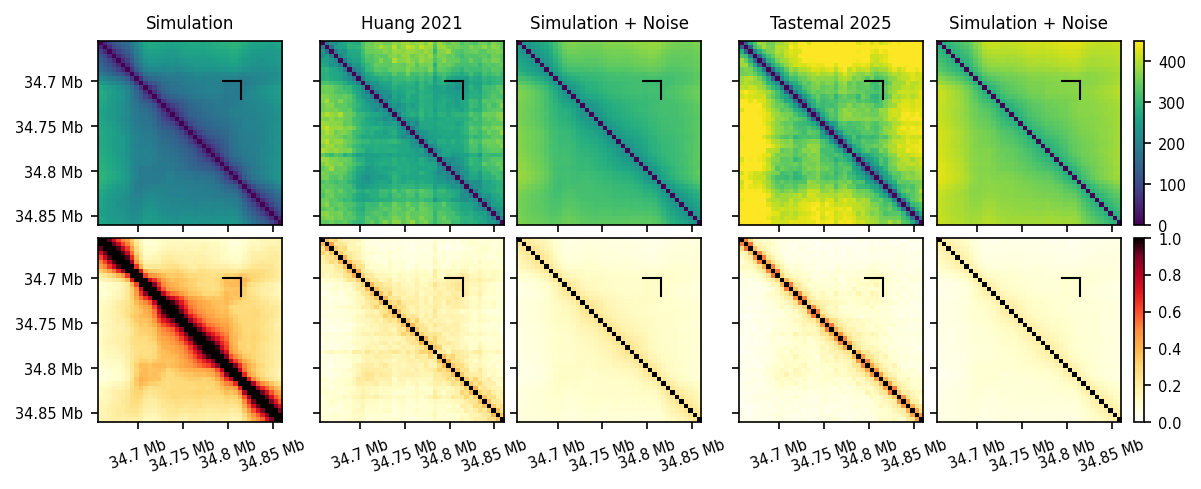

In [21]:
def positions_to_average_distance(positions, average=np.nanmedian):
    return average(positions_to_distances(positions), axis=0)

def plot_pairwise(data, region, **kwargs):
    chrom, start, end = parse_region(region)
    resolution = (end - start) // len(data)
    return ContactMap(data, chrom, start, end, resolution).plot_contact_map(**kwargs)


C = 150
max_dist = 450
track = orca['Tastemal 2025']
region = '{}:{}-{}'.format(chrom, track.regions[0][0], track.regions[-1][1])
cmap = 'viridis'
sox2 = 34_700_000
scr = 34_815_000

small_space = 0.07
big_space = 0.2
f, ax = plt.subplots(2, 5 + 5 + 1, figsize=(9, 3.3),
                     gridspec_kw={'width_ratios': [1, big_space,
                                                   1, small_space, 1, big_space,
                                                   1, small_space, 1, small_space, 0.05],
                                  'wspace': 0, 'hspace': small_space})
sim = simulation_tastemal['simulation']
sim_dists = positions_to_average_distance(sim.positions)
sim_contacts = positions_to_contacts(sim.positions, C)

ax[0, 0].set_title('Simulation', size=8)
im = plot_pairwise(sim_dists, region, ax=ax[0, 0], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)
plt.colorbar(im, cax=ax[0, -1], shrink=0.8)
im = plot_pairwise(sim_contacts, region, ax=ax[1, 0], vmax=1, vmin=0, log_norm=False, cmap='fall', colorbar=False)
plt.colorbar(im, cax=ax[1, -1], shrink=0.8)

for i, name in enumerate(['Huang 2021', 'Tastemal 2025']):
    i = 4*i + 2

    track = orca[name]
    dists = positions_to_average_distance(track.positions)
    contacts = positions_to_contacts(track.positions, C)

    ax[0, i].set_title(name, size=8)
    plot_pairwise(dists, region, ax=ax[0, i], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)
    plot_pairwise(contacts, region, ax=ax[1, i], vmax=1, vmin=0, log_norm=False, cmap='fall', colorbar=False)

    sim_noisy = simulation_tastemal['simulation'].__copy__()
    sim_noisy.positions = noise[name].add_noise(sim_noisy.positions, samples=50)
    dists = positions_to_average_distance(sim_noisy.positions)
    contacts = positions_to_contacts(sim_noisy.positions, C)
    
    ax[0, i+2].set_title('Simulation + Noise', size=8)
    plot_pairwise(dists, region, ax=ax[0, i+2], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)
    plot_pairwise(contacts, region, ax=ax[1, i+2], vmax=1, vmin=0, log_norm=False, cmap='fall', colorbar=False)

for i in range(11):
    ax[0, i].set_xticklabels([])

for i in range(1, 10):
    ax[0, i].set_yticklabels([])
    ax[1, i].set_yticklabels([])

for i in range(1, 11, 2):
    ax[0, i].axis('off')
    ax[1, i].axis('off')

for i in range(0, 11, 2):
    for j in range(2):
        ax[j, i].plot([scr-20_000, scr], [sox2, sox2], 'k', lw=1)
        ax[j, i].plot([scr, scr], [sox2, sox2+20_000], 'k', lw=1)

for a in ax.flatten():
    a.tick_params(labelsize=7)
plt.savefig('img/orca_new_sox2_maps.pdf', bbox_inches='tight')
plt.show()

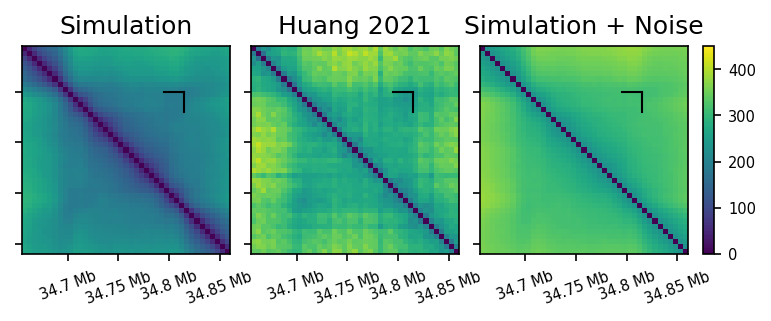

In [40]:
name = 'Huang 2021'
max_dist = 450
track = orca[name]
region = '{}:{}-{}'.format(chrom, track.regions[0][0], track.regions[-1][1])
cmap = 'viridis'
sox2 = 34_700_000
scr = 34_815_000

f, ax = plt.subplots(1, 4, figsize=(6, 1.8),
                     gridspec_kw={'width_ratios': [1, 1, 1, 0.05], 'wspace': 0.05,})
sim = simulation_tastemal['simulation']
sim_dists = positions_to_average_distance(sim.positions)

ax[0].set_title('Simulation', size=12)
im = plot_pairwise(sim_dists, region, ax=ax[0], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)
plt.colorbar(im, cax=ax[-1], shrink=0.8)

dists = positions_to_average_distance(track.positions)

ax[1].set_title(name, size=12)
plot_pairwise(dists, region, ax=ax[1], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)

sim_noisy = simulation_tastemal['simulation'].__copy__()
sim_noisy.positions = noise[name].add_noise(sim_noisy.positions, samples=50)
dists = positions_to_average_distance(sim_noisy.positions)
    
ax[2].set_title('Simulation + Noise', size=12)
plot_pairwise(dists, region, ax=ax[2], vmax=max_dist, vmin=0, log_norm=False, cmap=cmap, colorbar=False)


for i in range(3):
    ax[i].set_yticklabels([])

for i in range(0, 3):
    ax[i].plot([scr-20_000, scr], [sox2, sox2], 'k', lw=1)
    ax[i].plot([scr, scr], [sox2, sox2+20_000], 'k', lw=1)

for a in ax.flatten():
    a.tick_params(labelsize=7)
plt.savefig('img/orca_new_sox2_maps_main.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_1232052/1871712558.py:80: RuntimeWarning: invalid value encountered in divide
  plot_pairwise(np.log2(sim_noisy_dists / orca_dists), region, ax=ax[3], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)


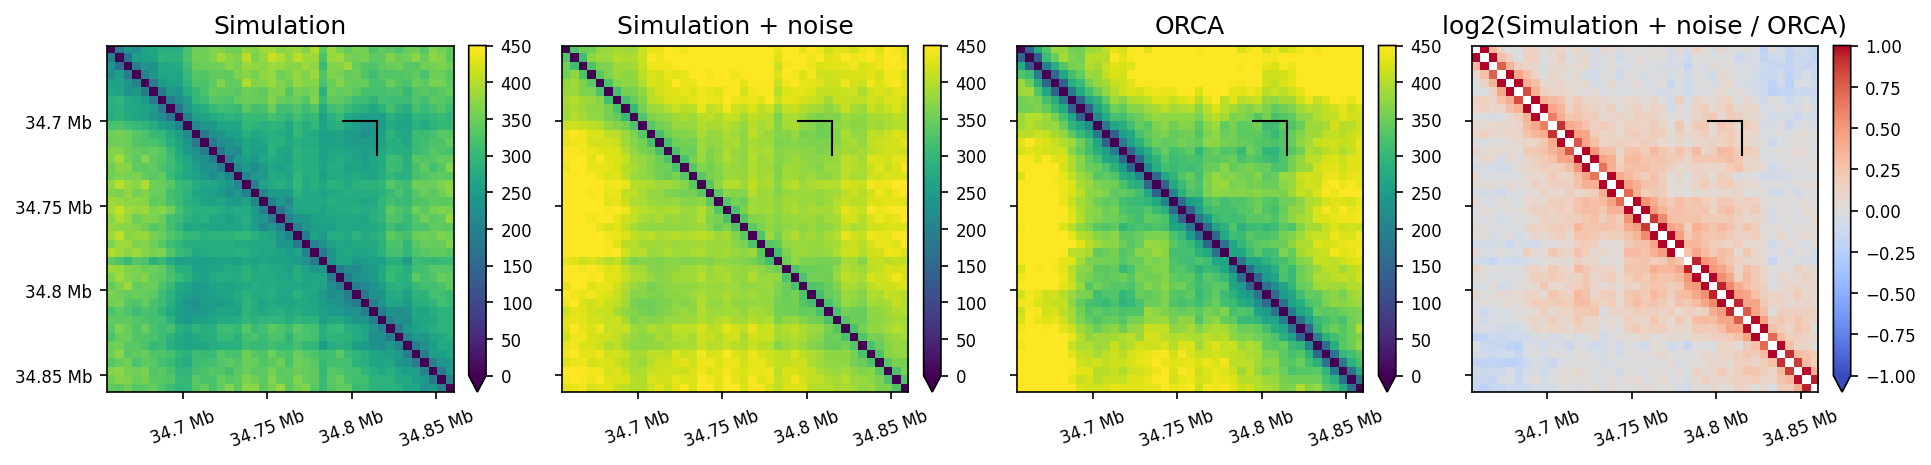

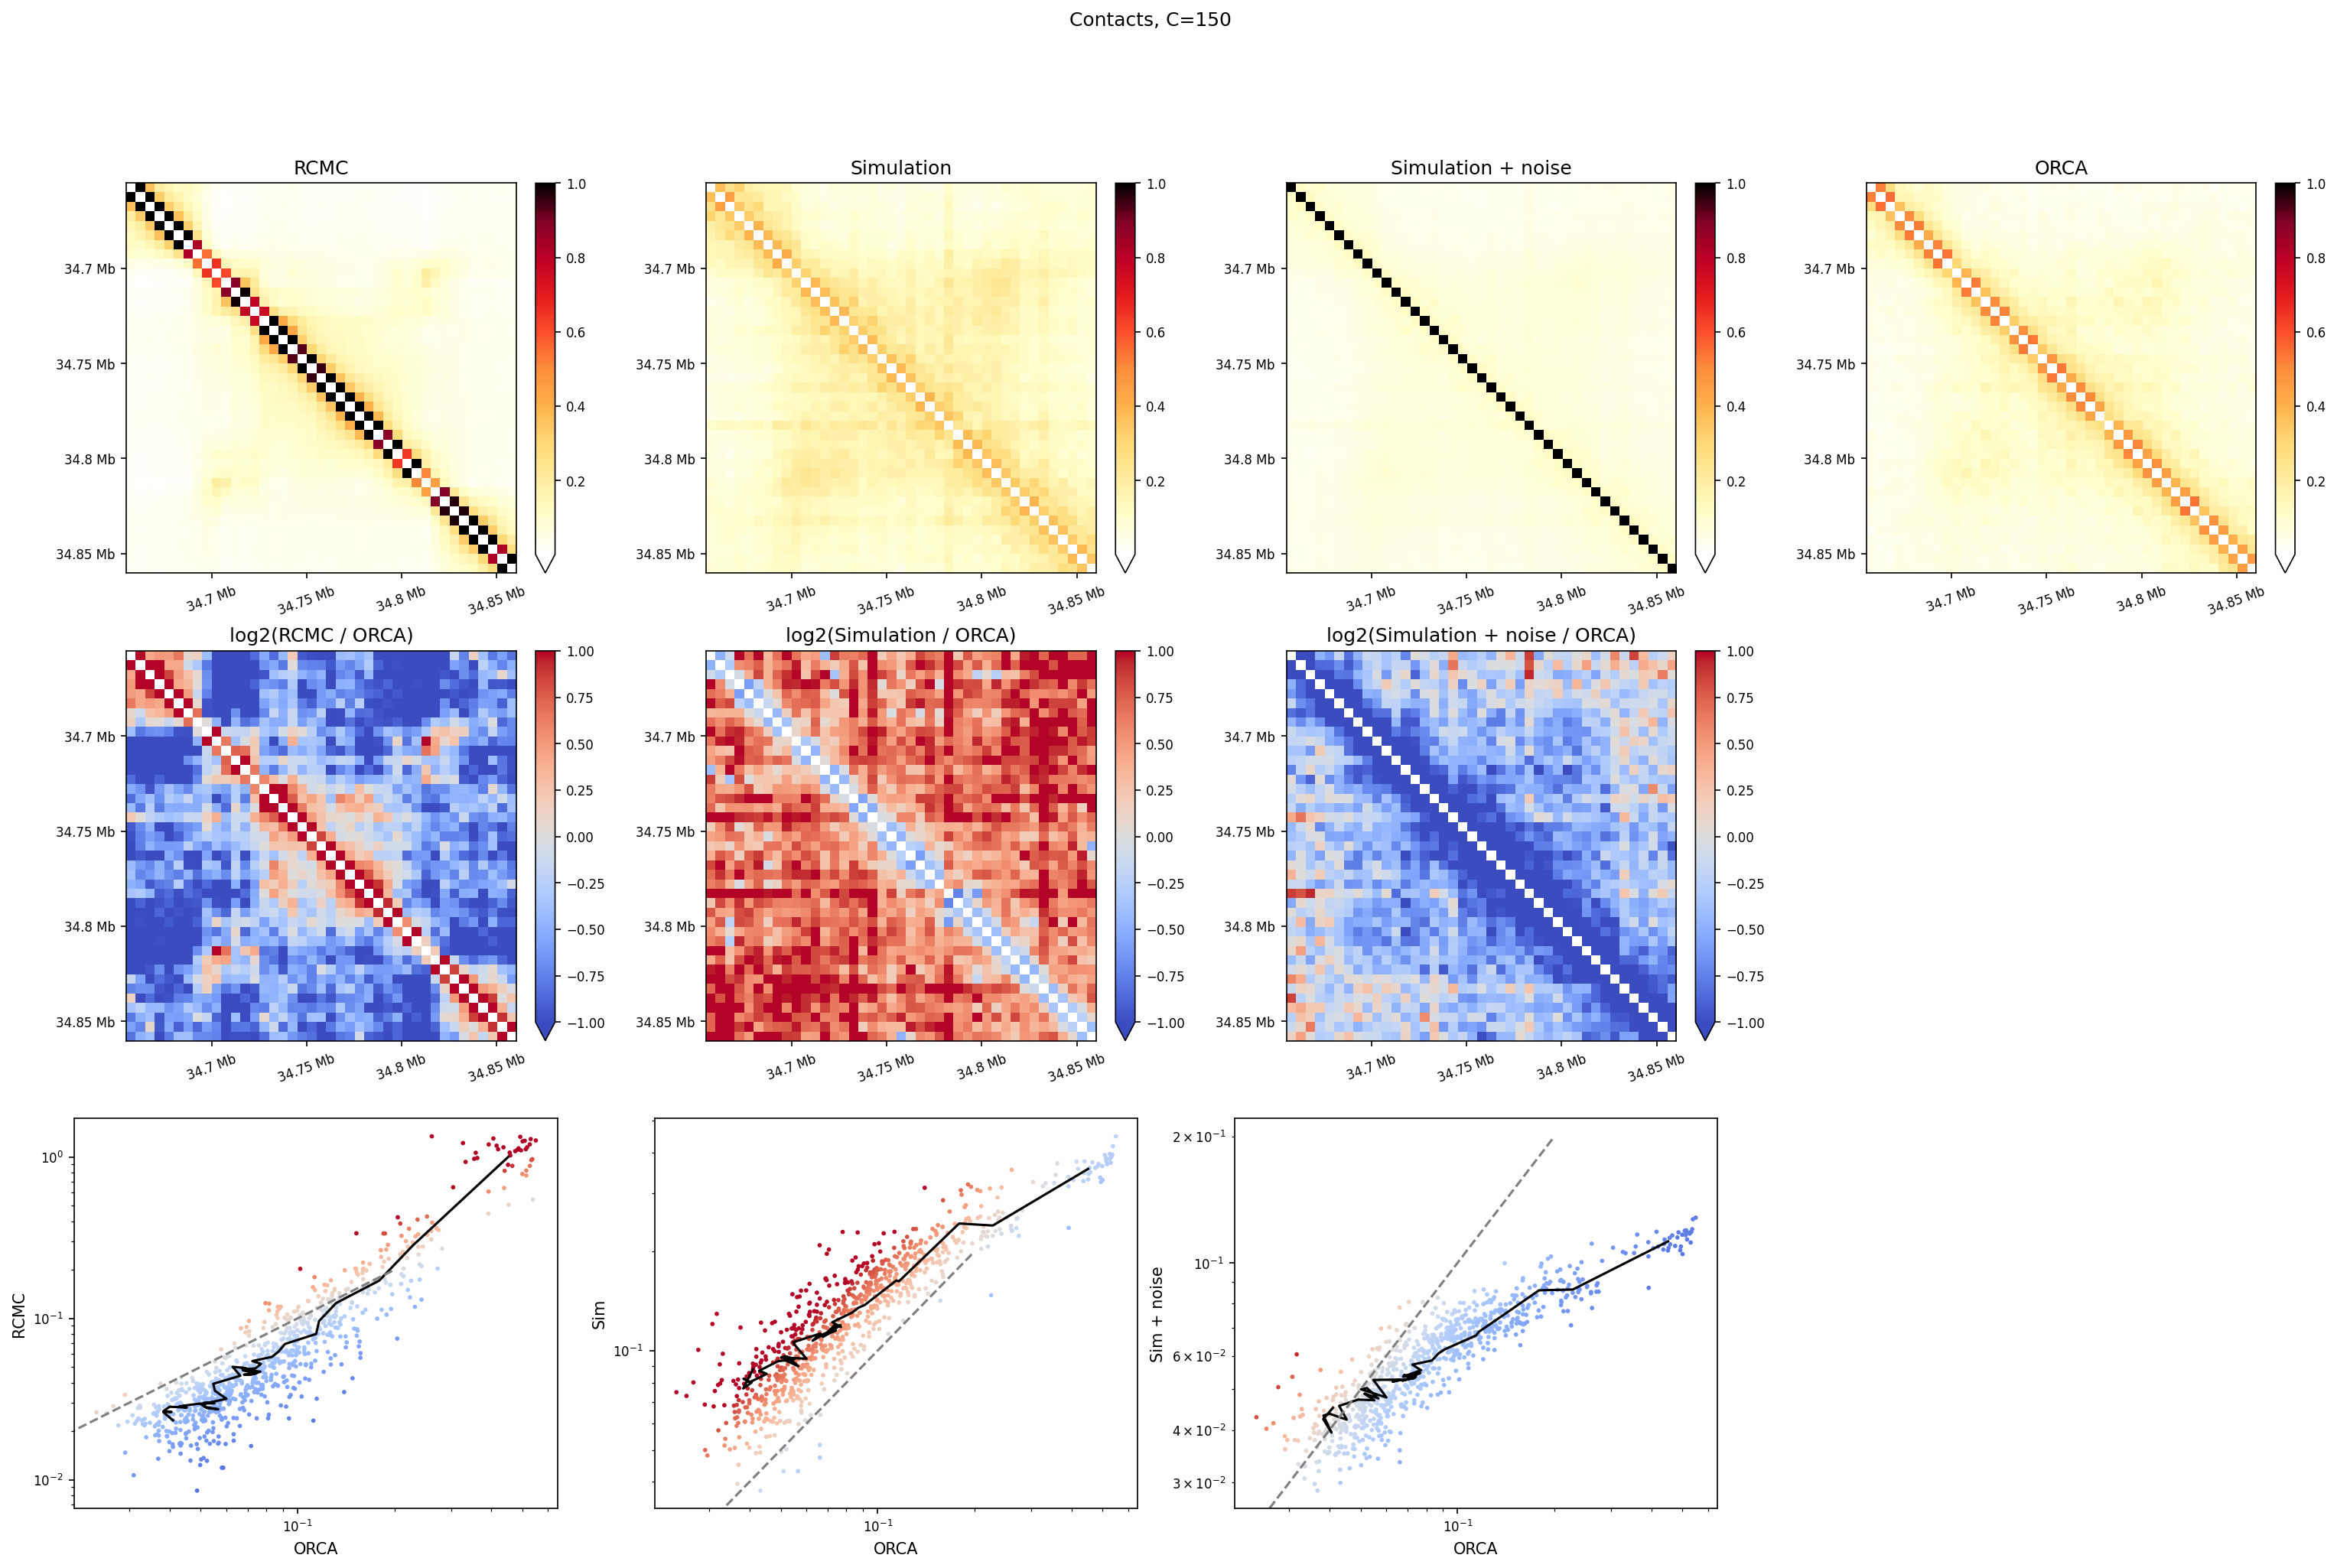

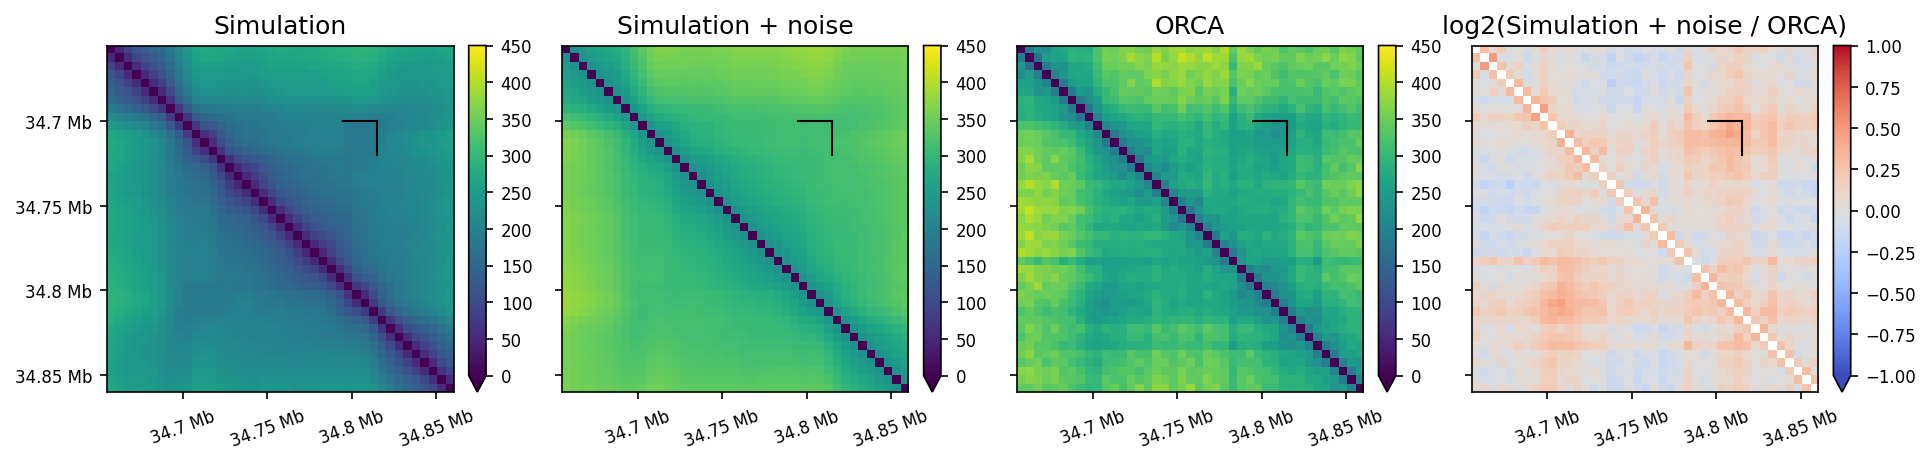

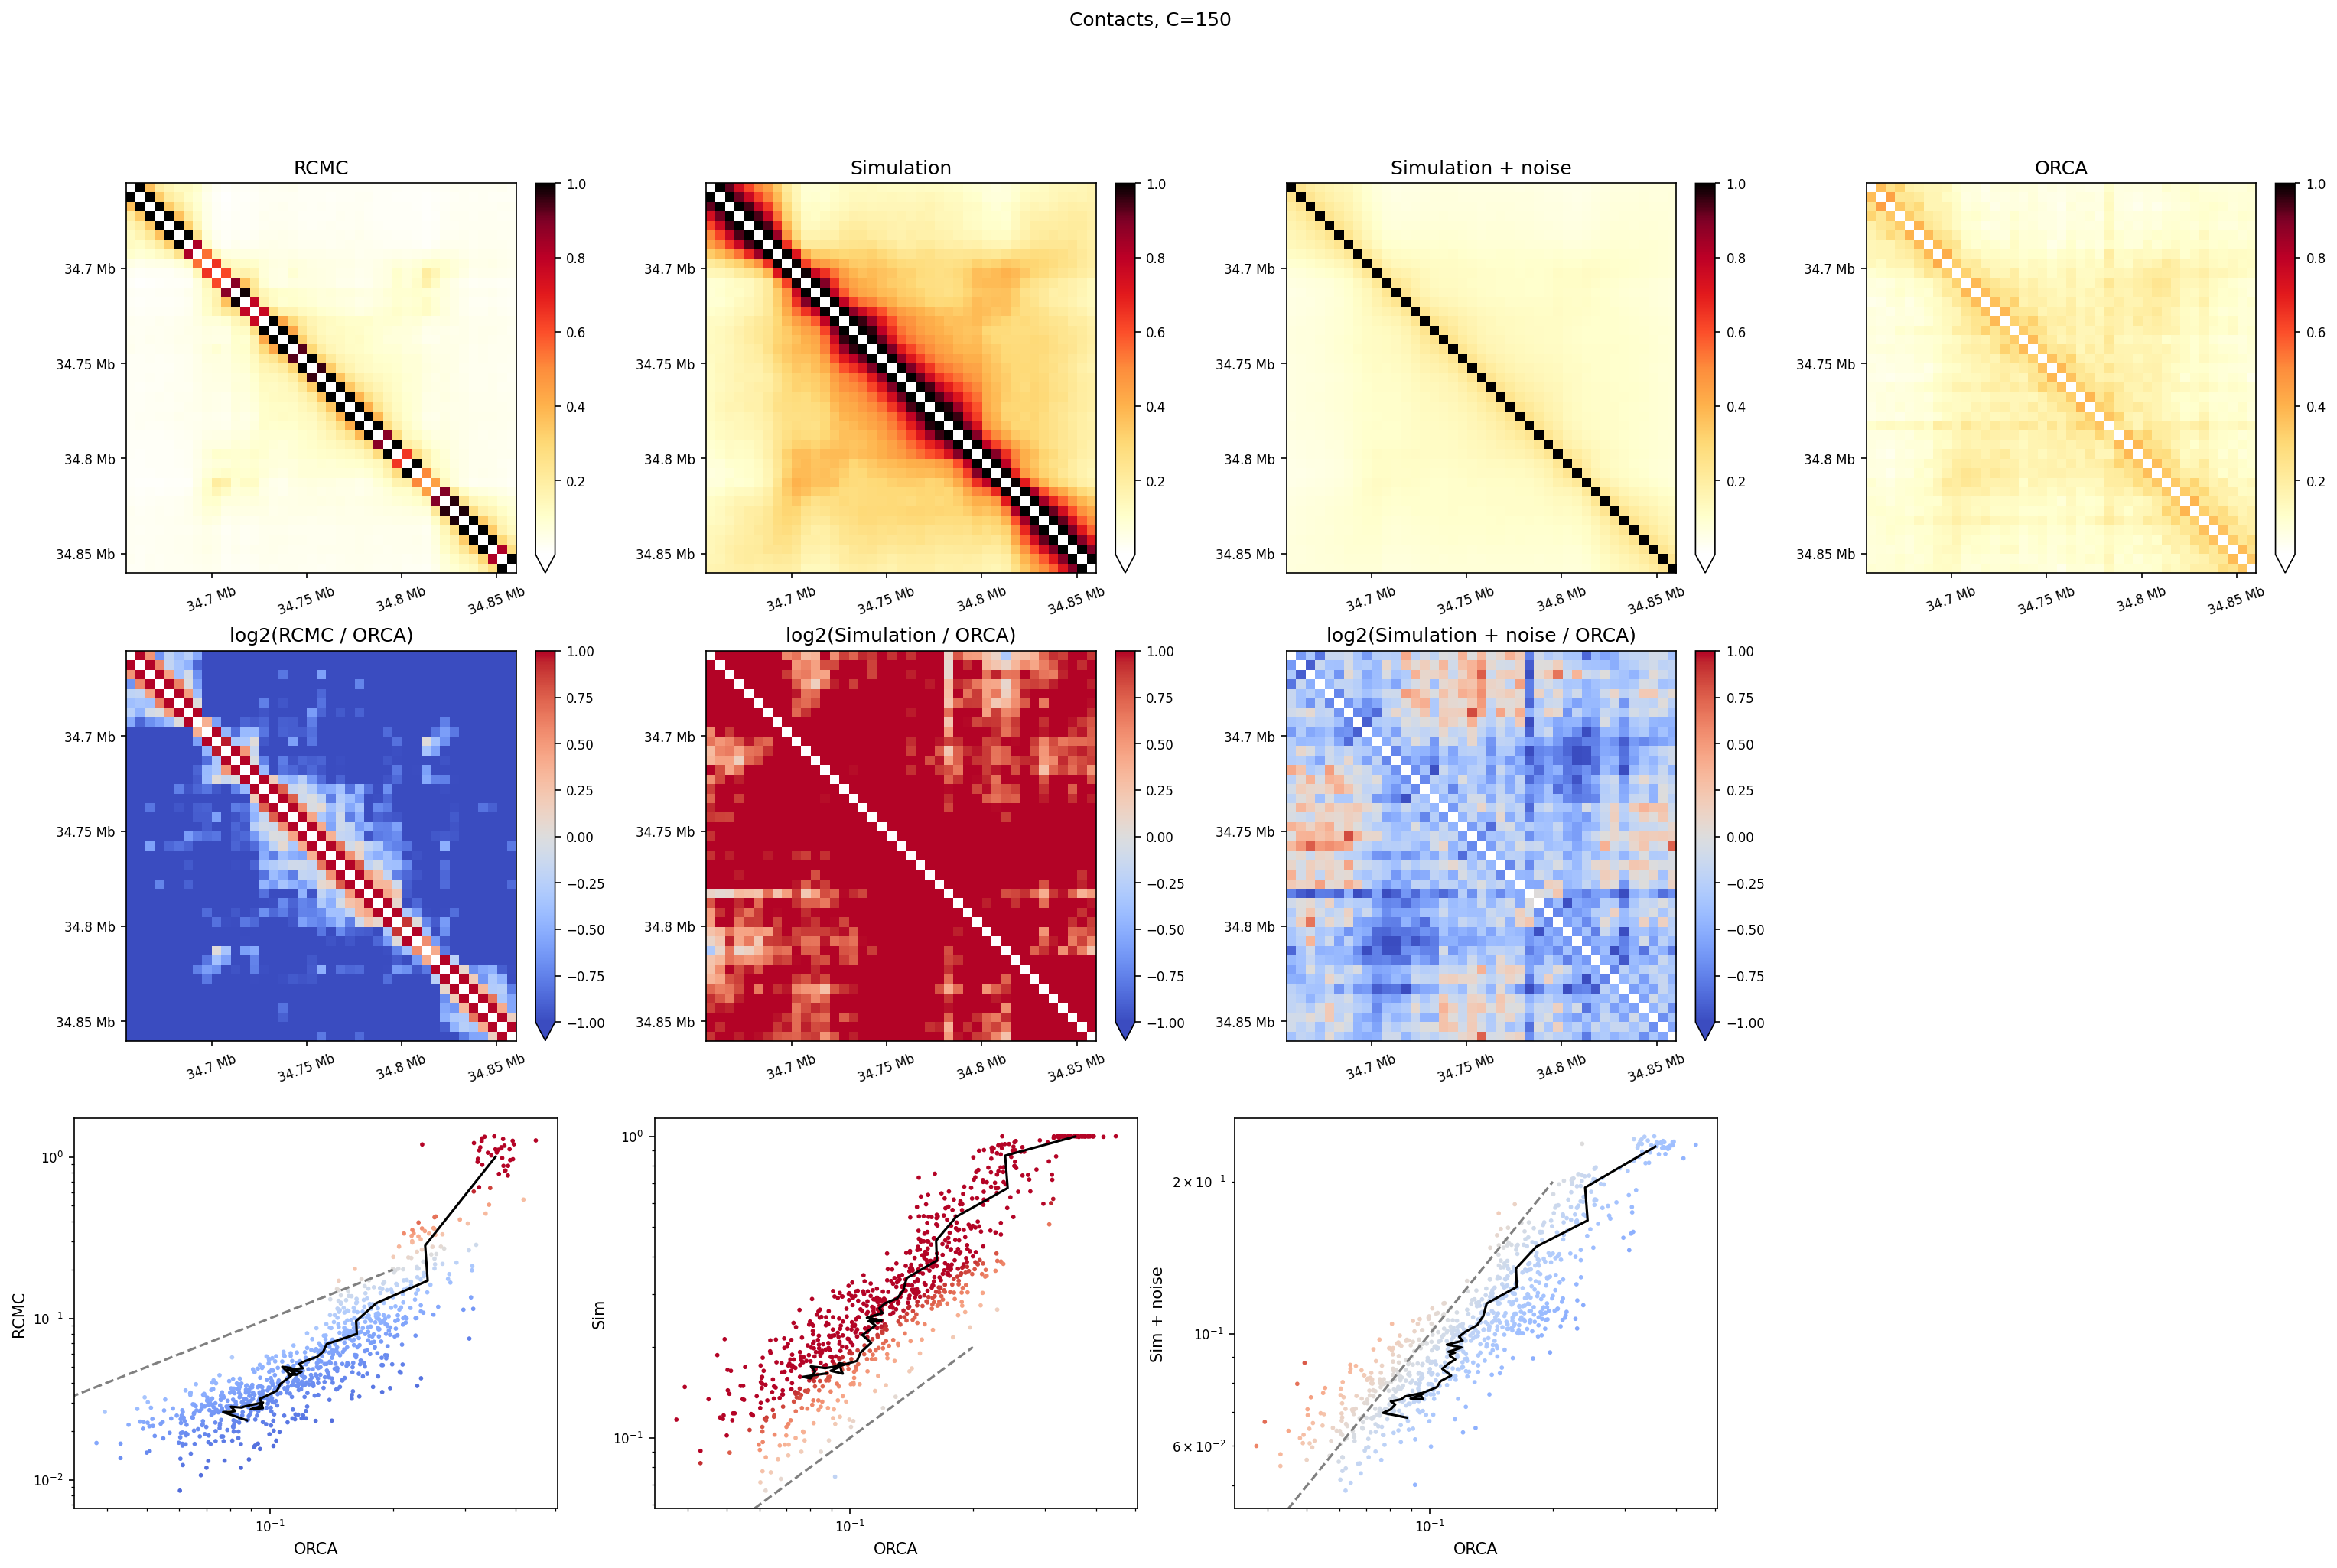

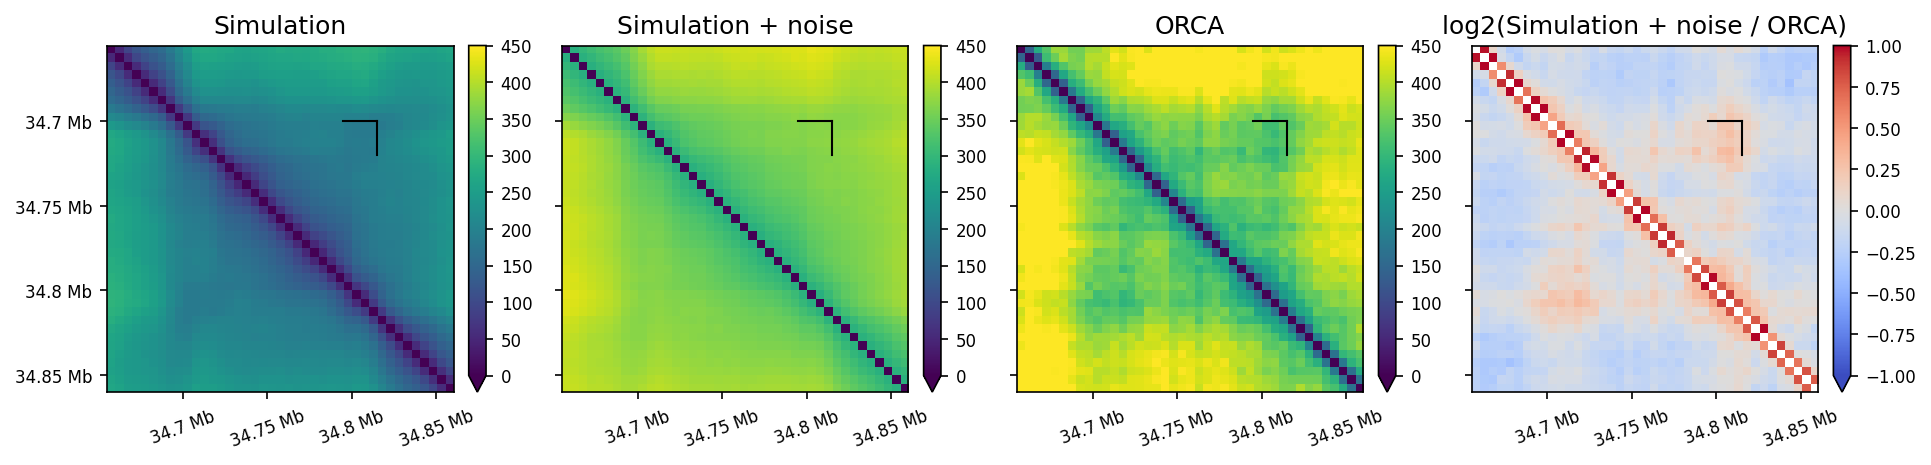

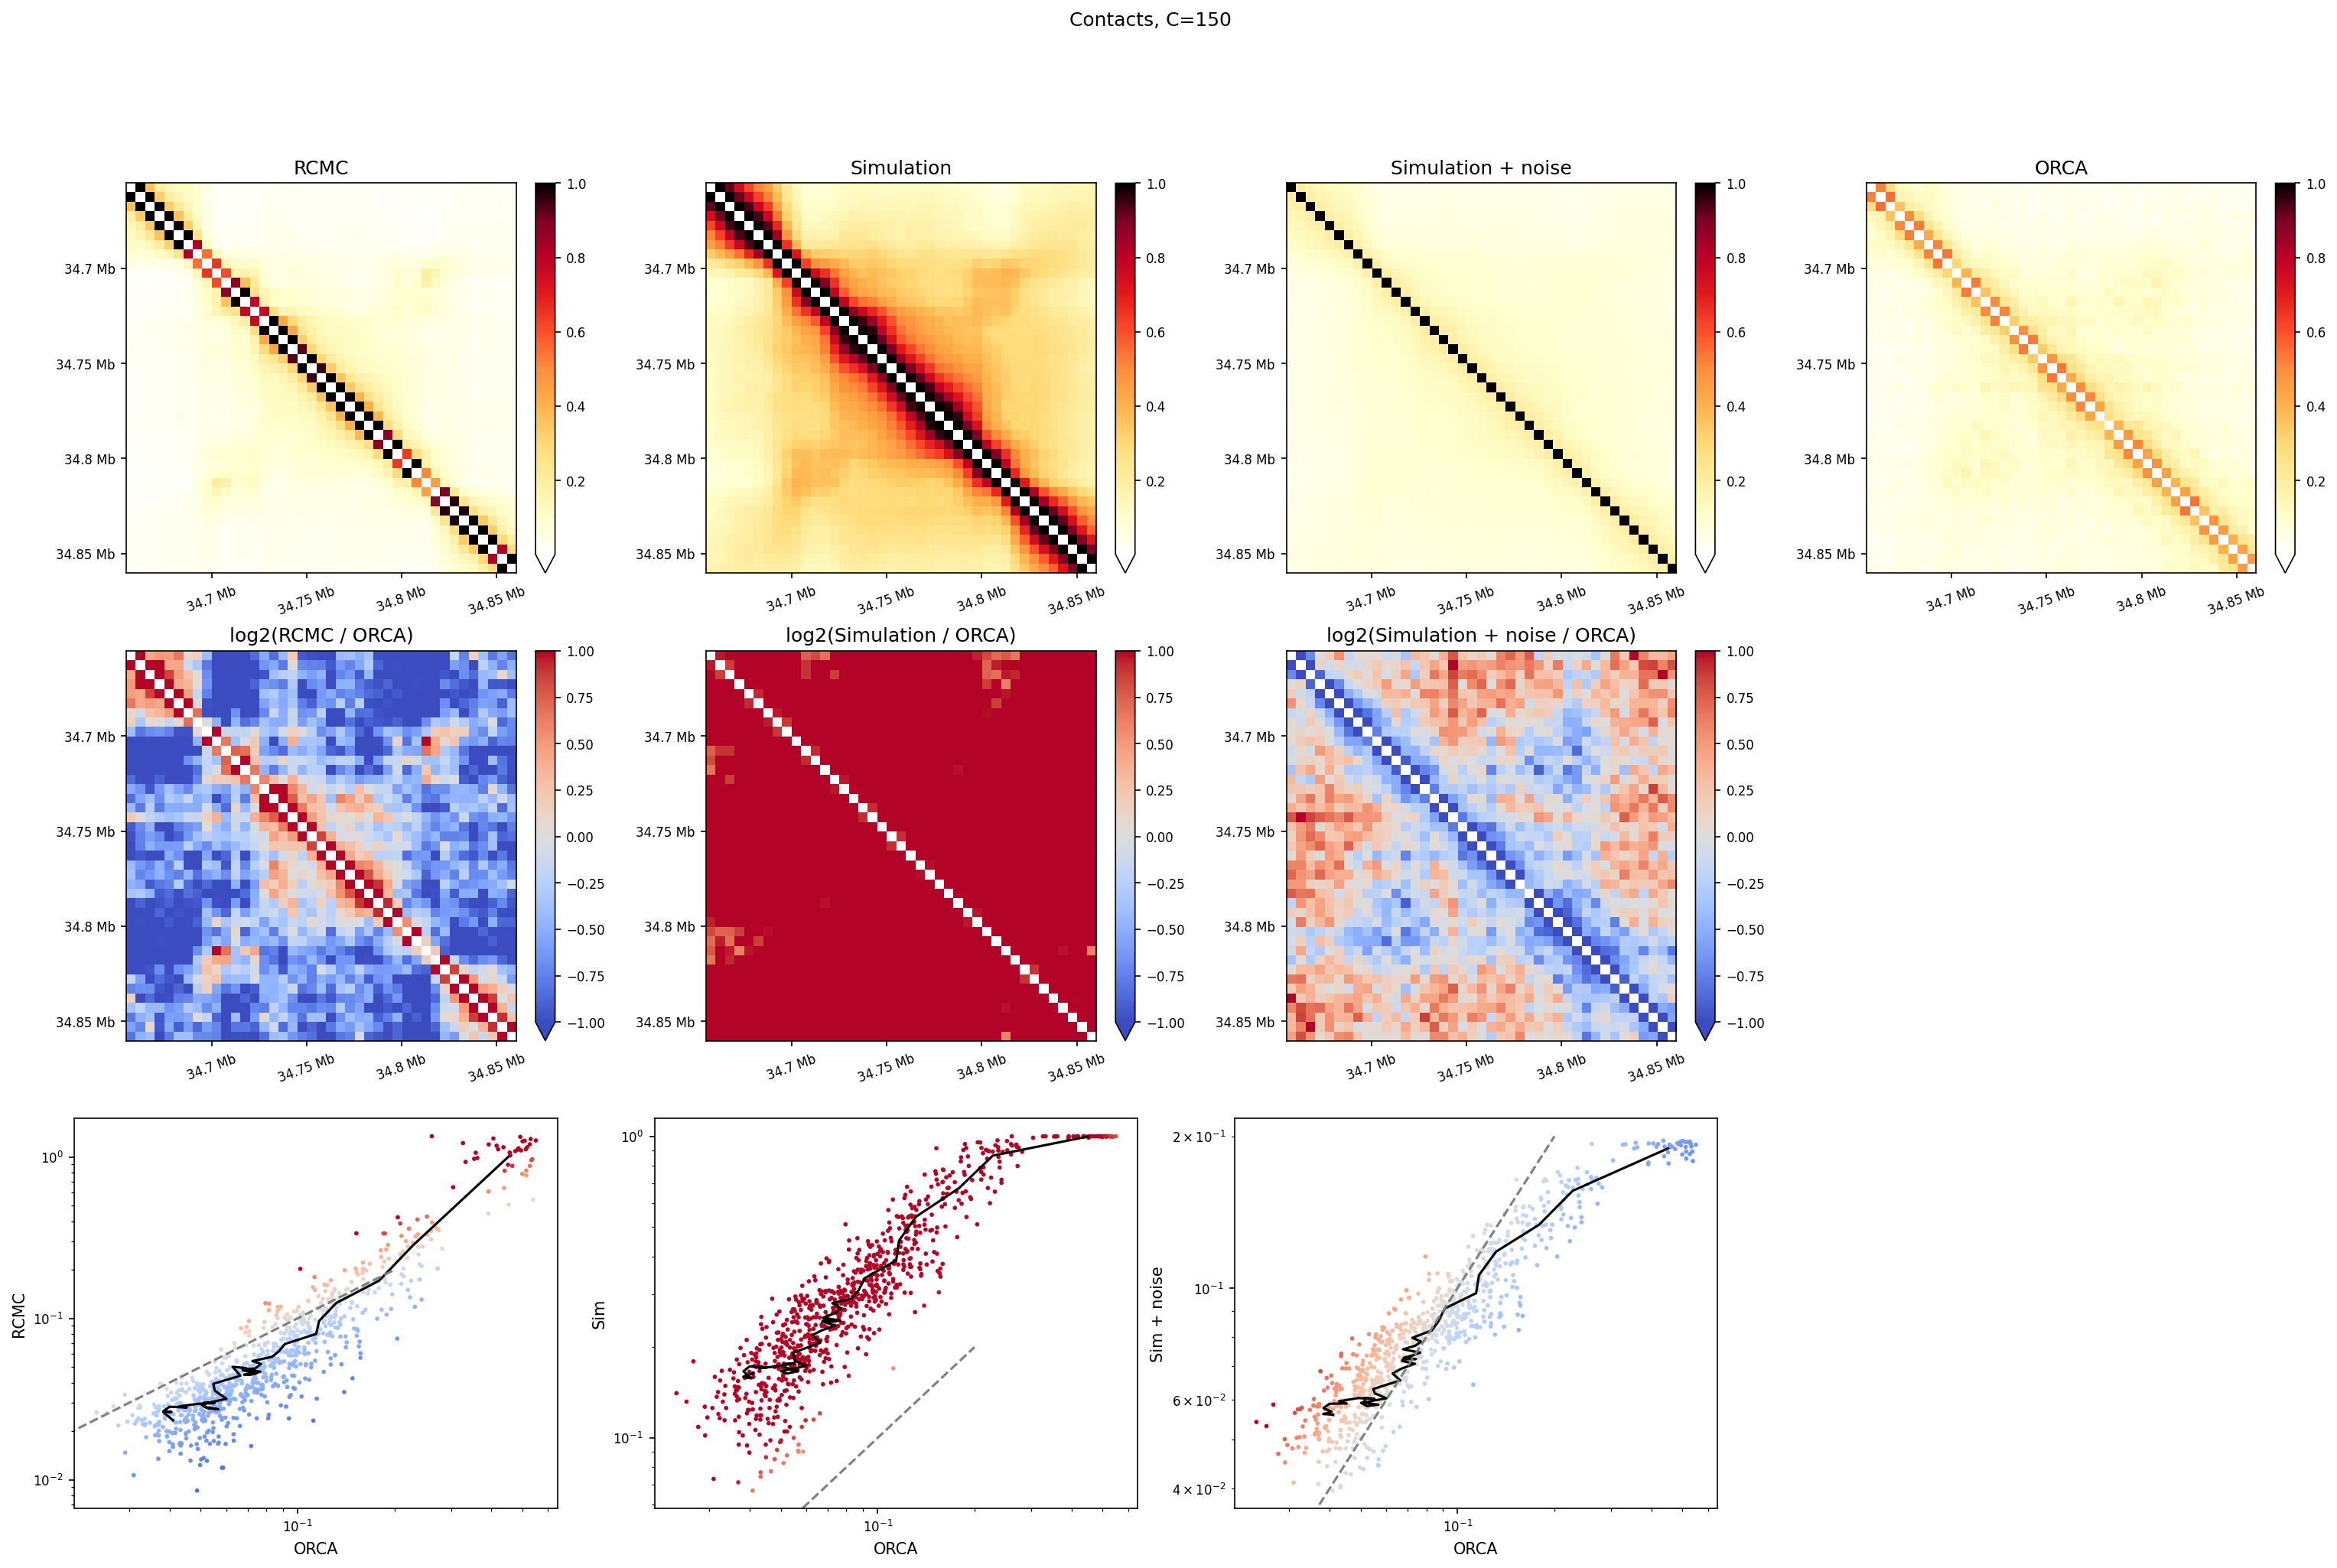

In [38]:
def compare_contacts(orca, simulation, simulation_noisy, contact_map, region, C):
    orca_contacts = positions_to_contacts(orca.positions, C)

    rcmc_contacts = contact_map.copy()
    sim_contacts = positions_to_contacts(simulation.positions, C)
    sim_noisy_contacts = positions_to_contacts(simulation_noisy.positions, C)

    np.fill_diagonal(orca_contacts, np.nan)
    np.fill_diagonal(rcmc_contacts, np.nan)
    np.fill_diagonal(sim_contacts, np.nan)

    f, ax = plt.subplots(3, 4, figsize=(25, 15))

    cmap = 'fall'
    vmin = 1e-3
    vmax = 1
    ax[0, 0].set_title('RCMC')
    plot_pairwise(rcmc_contacts, region, ax=ax[0, 0], vmax=vmax, vmin=vmin, log_norm=False, cmap=cmap)
    ax[0, 1].set_title('Simulation')
    plot_pairwise(sim_contacts, region, ax=ax[0, 1], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[0, 2].set_title('Simulation + noise')
    plot_pairwise(sim_noisy_contacts, region, ax=ax[0, 2], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[0, 3].set_title('ORCA')
    plot_pairwise(orca_contacts, region, ax=ax[0, 3], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)

    cmap = 'coolwarm'
    vmin = -1
    vmax = 1
    ax[1, 0].set_title('log2(RCMC / ORCA)')
    plot_pairwise(np.log2(rcmc_contacts / orca_contacts), region, ax=ax[1, 0], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[1, 1].set_title('log2(Simulation / ORCA)')
    plot_pairwise(np.log2(sim_contacts / orca_contacts), region, ax=ax[1, 1], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[1, 2].set_title('log2(Simulation + noise / ORCA)')
    plot_pairwise(np.log2(sim_noisy_contacts / orca_contacts), region, ax=ax[1, 2], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[1, 3].axis('off')

    def scatter(ax, x, y):
        _x = full_to_triu(x, k=1)
        _y = full_to_triu(y, k=1)
        ax.scatter(_x, _y, c=(_y-_x)/_x, cmap=cmap, vmin=vmin, vmax=vmax, s=3)

        _x = [np.diagonal(x, i).mean() for i in range(1, x.shape[0])]
        _y = [np.diagonal(y, i).mean() for i in range(1, y.shape[0])]
        ax.plot(_x, _y, color='black')

        ax.plot([0, .2], [0, .2], color='grey', linestyle='--')
        ax.set_xlabel('ORCA')
        ax.set_yscale('log')
        ax.set_xscale('log')

    ax[2, 0].set_ylabel('RCMC')
    scatter(ax[2, 0], orca_contacts, rcmc_contacts)
    ax[2, 1].set_ylabel('Sim')
    scatter(ax[2, 1], orca_contacts, sim_contacts)
    ax[2, 2].set_ylabel('Sim + noise')
    scatter(ax[2, 2], orca_contacts, sim_noisy_contacts)
    ax[2, 3].axis('off')

def compare_dists(orca, simulation, simulation_noisy, region, max_dist=600, k=2):
    orca_dists = positions_to_average_distance(orca.positions[:, :, :k])
    sim_dists = positions_to_average_distance(simulation.positions[:, :, :k])
    sim_noisy_dists = positions_to_average_distance(simulation_noisy.positions[:, :, :k])

    f, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

    cmap = 'viridis'
    vmin = 0
    vmax = max_dist
    ax[0].set_title('Simulation')
    plot_pairwise(sim_dists, region, ax=ax[0], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[1].set_title('Simulation + noise')
    plot_pairwise(sim_noisy_dists, region, ax=ax[1], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    ax[2].set_title('ORCA')
    plot_pairwise(orca_dists, region, ax=ax[2], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)

    cmap = 'coolwarm'
    vmin = -1
    vmax = 1
    ax[3].set_title('log2(Simulation + noise / ORCA)')
    plot_pairwise(np.log2(sim_noisy_dists / orca_dists), region, ax=ax[3], vmax=vmax, vmin=vmin, cmap=cmap, log_norm=False)
    return ax

track = orca['Tastemal 2025']
region = '{}:{}-{}'.format(chrom, track.regions[0][0], track.regions[-1][1])
k = 3
C=150
sox2 = 34_700_000
scr = 34_815_000
max_dist = 450

sim = orca['Huang 2021']
sim_noisy = sim.__copy__()
sim_noisy.positions = NoiseDistribution('t', scale=60, shape=2.0).add_noise(sim_noisy.positions, samples=50)
ax = compare_dists(orca['Tastemal 2025'],
              sim,
              sim_noisy,
              region, max_dist=max_dist, k=k)

for a in ax:
    a.plot([scr-20_000, scr], [sox2, sox2], 'k', lw=1)
    a.plot([scr, scr], [sox2, sox2+20_000], 'k', lw=1)
plt.show()

compare_contacts(orca['Tastemal 2025'], sim, sim_noisy,
                 neighbor_contact_map.contact_map, region, C)
plt.suptitle(f'Contacts, C={C}')
plt.show()


for orca_name in ['Huang 2021', 'Tastemal 2025']:
    sim = simulation_tastemal['simulation']
    sim_noisy = simulation_tastemal['simulation'].__copy__()
    sim_noisy.positions = noise[orca_name].add_noise(sim_noisy.positions, samples=50)
    ax = compare_dists(orca[orca_name], sim, sim_noisy, region, max_dist=max_dist, k=k)
    for a in ax:
        a.plot([scr-20_000, scr], [sox2, sox2], 'k', lw=1)
        a.plot([scr, scr], [sox2, sox2+20_000], 'k', lw=1)
    
    plt.show()


    C=150
    compare_contacts(orca[orca_name], sim, sim_noisy,
                     neighbor_contact_map.contact_map, region, C)
    plt.suptitle(f'Contacts, C={C}')
    plt.show()